In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/smart-meters-in-london/darksky_parameters_documentation.html
/kaggle/input/smart-meters-in-london/weather_hourly_darksky.csv
/kaggle/input/smart-meters-in-london/acorn_details.csv
/kaggle/input/smart-meters-in-london/uk_bank_holidays.csv
/kaggle/input/smart-meters-in-london/weather_daily_darksky.csv
/kaggle/input/smart-meters-in-london/daily_dataset.csv
/kaggle/input/smart-meters-in-london/informations_households.csv
/kaggle/input/smart-meters-in-london/hhblock_dataset/hhblock_dataset/block_97.csv
/kaggle/input/smart-meters-in-london/hhblock_dataset/hhblock_dataset/block_27.csv
/kaggle/input/smart-meters-in-london/hhblock_dataset/hhblock_dataset/block_55.csv
/kaggle/input/smart-meters-in-london/hhblock_dataset/hhblock_dataset/block_0.csv
/kaggle/input/smart-meters-in-london/hhblock_dataset/hhblock_dataset/block_2.csv
/kaggle/input/smart-meters-in-london/hhblock_dataset/hhblock_dataset/block_9.csv
/kaggle/input/smart-meters-in-london/hhblock_dataset/hhblock_dataset/block_3

In [308]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 3.7 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.3-py2.py3-none-any.whl size=317840629 sha256=2929f84b6e15fa5a32e9b8b5c7779a8778267c1d738f48ec2515d27a7986311f
  Stored in directory: /root/.cache/pip/wheels/1b/3a/92/28b93e2fbfdbb07509ca4d6f50c5e407f48dce4ddbda69a4ab
Successfully built pyspark


In [8]:
pip install --upgrade visions numba


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 5.5 MB/s eta 0:00:00
  Attempting uninstall: visions
    Found existing installation: visions 0.7.5
    Uninstalling visions-0.7.5:
      Successfully uninstalled visions-0.7.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.12.0 requires scipy<1.14,>=1.4.1, but you have scipy 1.14.1 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [309]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import IPython
import IPython.display
import glob
import time
import pickle
import sys
from sklearn.inspection import permutation_importance
import warnings


from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.functions import pandas_udf, PandasUDFType

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col


warnings.filterwarnings("ignore")
randomState = 42 # tip of the cap to Douglas Adams

In [310]:
spark = SparkSession.builder.appName('Smart-Meter-Analysis').getOrCreate()
spark

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/13 01:35:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [311]:
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=Smart-Meter-Analysis>

In [312]:
sqlContext = SQLContext(spark.sparkContext)
sqlContext

In [4]:
path = '/kaggle/input/smart-meters-in-london/halfhourly_dataset/halfhourly_dataset'
csv_files = glob.glob(path + "/*.csv")

# Read each CSV file into DataFrame
# This creates a list of dataframes
start_time = time.time()
df_list = (pd.read_csv(file, parse_dates=["tstp"]) for file in csv_files)
print('%s seconds' % (time.time() - start_time))

# Concatenate all DataFrames
start_time = time.time()
d = pd.concat(df_list, ignore_index=True)
print('%s seconds' % (time.time() - start_time))

0.0001621246337890625 seconds
202.6572904586792 seconds


In [5]:

columns = d.columns

# Print the columns
print(columns)

Index(['LCLid', 'tstp', 'energy(kWh/hh)'], dtype='object')


In [ ]:
spark_all_energy=spark.createDataFrame(d) 
spark_all_energy.printSchema()

In [6]:
weatherData = pd.read_csv('/kaggle/input/smart-meters-in-london/weather_hourly_darksky.csv', parse_dates=["time"])

In [7]:
weatherData.describe()

visibility   windBearing   temperature  \
count  21165.000000  21165.000000  21165.000000   
mean      11.166485    195.685897     10.471486   
min        0.180000      0.000000     -5.640000   
25%       10.120000    121.000000      6.470000   
50%       12.260000    217.000000      9.930000   
75%       13.080000    256.000000     14.310000   
max       16.090000    359.000000     32.400000   
std        3.099337     90.629453      5.781904   

                                time      dewPoint      pressure  \
count                          21165  21165.000000  21152.000000   
mean   2013-01-14 22:27:36.697377792      6.530501   1014.125153   
min              2011-11-01 00:00:00     -9.980000    975.740000   
25%              2012-06-08 11:00:00      2.820000   1007.430000   
50%              2013-01-14 22:00:00      6.570000   1014.780000   
75%              2013-08-23 09:00:00     10.330000   1022.050000   
max              2014-03-31 22:00:00     19.880000   1043.320000   
std                              NaN      5.041965     11.388337   

       apparentTemperature     windSpeed      humidity  
count         21165.000000  21165.000000  21165.000000  
mean              9.230338      3.905215      0.781829  
min              -8.880000      0.040000      0.230000  
25%               3.900000      2.420000      0.700000  
50%               9.360000      3.680000      0.810000  
75%              14.320000      5.070000      0.890000  
max              32.420000     14.800000      1.000000  
std               6.940919      2.026854      0.140369

In [8]:
weatherData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21165 entries, 0 to 21164
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   visibility           21165 non-null  float64       
 1   windBearing          21165 non-null  int64         
 2   temperature          21165 non-null  float64       
 3   time                 21165 non-null  datetime64[ns]
 4   dewPoint             21165 non-null  float64       
 5   pressure             21152 non-null  float64       
 6   apparentTemperature  21165 non-null  float64       
 7   windSpeed            21165 non-null  float64       
 8   precipType           21165 non-null  object        
 9   icon                 21165 non-null  object        
 10  humidity             21165 non-null  float64       
 11  summary              21165 non-null  object        
dtypes: datetime64[ns](1), float64(7), int64(1), object(3)
memory usage: 1.9+ MB


In [9]:
weatherData = weatherData.astype({'precipType':'string', 'icon':'string', 'summary':'string'})

In [10]:
from pandas_profiling import ProfileReport

profile = ProfileReport(weatherData, tsmode=True, sortby="time")
profile.to_file('weatherData profile_report.html')
# profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [11]:

offRecs = weatherData.query("time.dt.minute != 0 or time.dt.second != 0")
print('Records not exactly on the half-hour:\n ', offRecs)

Records not exactly on the half-hour:
  Empty DataFrame
Columns: [visibility, windBearing, temperature, time, dewPoint, pressure, apparentTemperature, windSpeed, precipType, icon, humidity, summary]
Index: []


In [12]:
# select weather data features of interest
weatherUpsample = weatherData[['time','temperature', 'dewPoint']].copy()
# weatherUpsample = weatherData[['time','temperature', 'dewPoint', 'pressure', 'humidity']].copy()
# pressure and humidity removed due to permutation feature importance results
weatherUpsample = weatherUpsample.sort_values(by=['time'])
print(weatherUpsample.info())
print(weatherUpsample.describe())
print(weatherUpsample)

<class 'pandas.core.frame.DataFrame'>
Index: 21165 entries, 312 to 20276
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   time         21165 non-null  datetime64[ns]
 1   temperature  21165 non-null  float64       
 2   dewPoint     21165 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 661.4 KB
None
                                time   temperature      dewPoint
count                          21165  21165.000000  21165.000000
mean   2013-01-14 22:27:36.697377792     10.471486      6.530501
min              2011-11-01 00:00:00     -5.640000     -9.980000
25%              2012-06-08 11:00:00      6.470000      2.820000
50%              2013-01-14 22:00:00      9.930000      6.570000
75%              2013-08-23 09:00:00     14.310000     10.330000
max              2014-03-31 22:00:00     32.400000     19.880000
std                              NaN      5.781904      5.041965

In [13]:
# get the index set up to support the resamle operation
weatherUpsample.set_index('time', inplace=True)
weatherUpsample.index.rename('time', inplace=True)

start_time = time.time()
weatherUpsample = weatherUpsample.resample('30Min').mean()

# upsample 
weatherUpsample['temperature'] = weatherUpsample['temperature'].interpolate()
weatherUpsample['dewPoint'] = weatherUpsample['dewPoint'].interpolate()
# weatherUpsample['pressure'] = weatherUpsample['pressure'].interpolate()
# weatherUpsample['humidity'] = weatherUpsample['humidity'].interpolate()

print('%s seconds' % (time.time() - start_time))

weatherUpsample = weatherUpsample.reset_index(names='DateTime')
print(weatherUpsample.info())
print(weatherUpsample.describe())
print(weatherUpsample)

0.01641845703125 seconds
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42333 entries, 0 to 42332
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   DateTime     42333 non-null  datetime64[ns]
 1   temperature  42333 non-null  float64       
 2   dewPoint     42333 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 992.3 KB
None
                  DateTime   temperature      dewPoint
count                42333  42333.000000  42333.000000
mean   2013-01-14 23:00:00     10.471414      6.530646
min    2011-11-01 00:00:00     -5.640000     -9.980000
25%    2012-06-08 11:30:00      6.475000      2.830000
50%    2013-01-14 23:00:00      9.935000      6.575000
75%    2013-08-23 10:30:00     14.320000     10.325000
max    2014-03-31 22:00:00     32.400000     19.880000
std                    NaN      5.775688      5.037766
                 DateTime  temperature  dewPoint
0     2011-1

In [14]:
# save weather data again
weatherUpsample.to_csv('/kaggle/working/WeatherDataFinal.csv',index=False)

In [15]:
# load pre-processed weather data
weatherUpsample = pd.read_csv('/kaggle/working/WeatherDataFinal.csv', parse_dates=["DateTime"])
weatherUpsample

DateTime  temperature  dewPoint
0     2011-11-01 00:00:00       13.490    11.480
1     2011-11-01 00:30:00       13.110    11.530
2     2011-11-01 01:00:00       12.730    11.580
3     2011-11-01 01:30:00       13.190    11.860
4     2011-11-01 02:00:00       13.650    12.140
...                   ...          ...       ...
42328 2014-03-31 20:00:00       13.620     7.910
42329 2014-03-31 20:30:00       13.325     7.935
42330 2014-03-31 21:00:00       13.030     7.960
42331 2014-03-31 21:30:00       12.770     7.965
42332 2014-03-31 22:00:00       12.510     7.970

[42333 rows x 3 columns]

In [16]:
# utility function to nicely format variable names and memory they are consuming
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

In [17]:
# ~1 minute
start_time = time.time()
d.iloc[:, 2] = pd.to_numeric(d.iloc[:, 2], errors='coerce')
print('%s seconds' % (time.time() - start_time))

# rename usage column for easier reference
d.rename(columns={d.columns[2]: 'kWhPerHalfHour'}, inplace=True)
d.info()

51.0154914855957 seconds
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167817021 entries, 0 to 167817020
Data columns (total 3 columns):
 #   Column          Dtype         
---  ------          -----         
 0   LCLid           object        
 1   tstp            datetime64[ns]
 2   kWhPerHalfHour  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 3.8+ GB


In [18]:
# set timestamp as the index
start_time = time.time()
d.set_index('tstp')
print('%s seconds' % (time.time() - start_time))

17.445169687271118 seconds


In [19]:
# about 1.5 minutes
start_time = time.time()
dupes = d[d.duplicated()]
print('dupes', dupes)
print('dupes.index', dupes.index)
d.drop(index=dupes.index, inplace=True)
print('%s seconds' % (time.time() - start_time))

dupes Empty DataFrame
Columns: [LCLid, tstp, kWhPerHalfHour]
Index: []
dupes.index Index([], dtype='int64')
75.36708641052246 seconds


In [20]:
# set index for the usage data to the timestamp column.  Is this necessary?  Can't remember why
start_time = time.time()
d.set_index('tstp')
d.info()
print('%s seconds' % (time.time() - start_time))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167817021 entries, 0 to 167817020
Data columns (total 3 columns):
 #   Column          Dtype         
---  ------          -----         
 0   LCLid           object        
 1   tstp            datetime64[ns]
 2   kWhPerHalfHour  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 3.8+ GB
16.744890689849854 seconds


In [21]:
# check what is gobbling RAM
for name, size in sorted(((name, sys.getsizeof(value)) for name, value in list(
                          locals().items())), key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                             d: 16.6 GiB
                   weatherData:  5.5 MiB
               weatherUpsample: 992.3 KiB
                           _15: 992.3 KiB
                            _7:  1.8 KiB
                 ProfileReport:  1.2 KiB
                     filenames:  1.1 KiB
                     csv_files:  1.1 KiB
                           _i2:  979.0 B
                          _i13:  801.0 B


In [22]:
rng = np.random.default_rng(randomState)
# random_state = np.random.RandomState(randomState)
sampleMeters = rng.choice(d.LCLid.unique(), size=int(len(d.LCLid.unique())*0.02), replace=False)
print('sampleMeters:\n', sampleMeters)
sample = d[d['LCLid'].isin(sampleMeters)]
print('sample:\n', sample)
print(sample.describe())

sampleMeters:
 ['MAC003787' 'MAC004997' 'MAC000079' 'MAC001558' 'MAC001656' 'MAC001938'
 'MAC003313' 'MAC001152' 'MAC002826' 'MAC000272' 'MAC000133' 'MAC001726'
 'MAC004462' 'MAC003604' 'MAC001933' 'MAC003085' 'MAC004775' 'MAC005467'
 'MAC002659' 'MAC005353' 'MAC003411' 'MAC005264' 'MAC000875' 'MAC001330'
 'MAC002750' 'MAC003007' 'MAC003705' 'MAC003049' 'MAC003468' 'MAC004190'
 'MAC002703' 'MAC000477' 'MAC000020' 'MAC003603' 'MAC001982' 'MAC003471'
 'MAC000878' 'MAC004084' 'MAC001267' 'MAC004947' 'MAC001665' 'MAC005543'
 'MAC001762' 'MAC003512' 'MAC000071' 'MAC000089' 'MAC005269' 'MAC004873'
 'MAC000118' 'MAC001493' 'MAC003876' 'MAC005095' 'MAC002583' 'MAC005132'
 'MAC004659' 'MAC004419' 'MAC002866' 'MAC002854' 'MAC001995' 'MAC004157'
 'MAC002860' 'MAC004271' 'MAC000407' 'MAC002805' 'MAC004927' 'MAC001184'
 'MAC001159' 'MAC002448' 'MAC003486' 'MAC001054' 'MAC003291' 'MAC005448'
 'MAC002654' 'MAC003222' 'MAC004803' 'MAC004460' 'MAC003087' 'MAC000214'
 'MAC003040' 'MAC000183' 'MAC000653'

In [24]:
sample.to_csv('/kaggle/working/sampleMeters.csv',index=False)

In [25]:

sample = pd.read_csv('/kaggle/working/sampleMeters.csv', parse_dates=["tstp"])
sample

LCLid                tstp  kWhPerHalfHour
0        MAC001330 2012-05-17 11:00:00           0.157
1        MAC001330 2012-05-17 11:30:00           0.192
2        MAC001330 2012-05-17 12:00:00           0.675
3        MAC001330 2012-05-17 12:30:00           0.418
4        MAC001330 2012-05-17 13:00:00           1.446
...            ...                 ...             ...
3410959  MAC005448 2014-02-27 22:00:00           0.144
3410960  MAC005448 2014-02-27 22:30:00           0.086
3410961  MAC005448 2014-02-27 23:00:00           0.053
3410962  MAC005448 2014-02-27 23:30:00           0.058
3410963  MAC005448 2014-02-28 00:00:00           0.048

[3410964 rows x 3 columns]

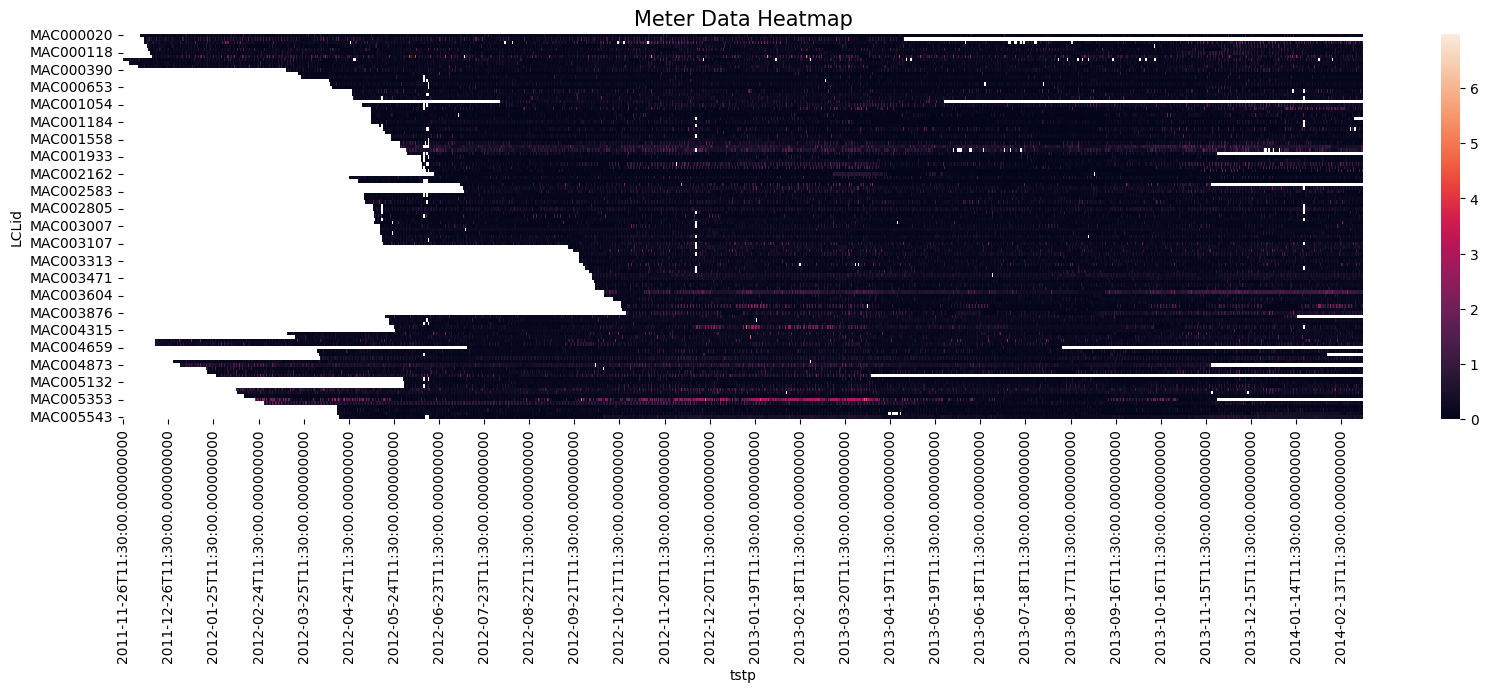

In [26]:
# visualize meter read coverage and completeness
# using a random sample of 2% of meters
import matplotlib.ticker as ticker
plt.subplots(figsize=(20,5))
pivot_table = pd.pivot_table(sample, columns='tstp', index='LCLid', values='kWhPerHalfHour')
sns.heatmap(pivot_table, xticklabels=48*30)
plt.title('Meter Data Heatmap', size=15)
plt.savefig('meter data heatmap.png', format='png')

5.991939067840576 seconds


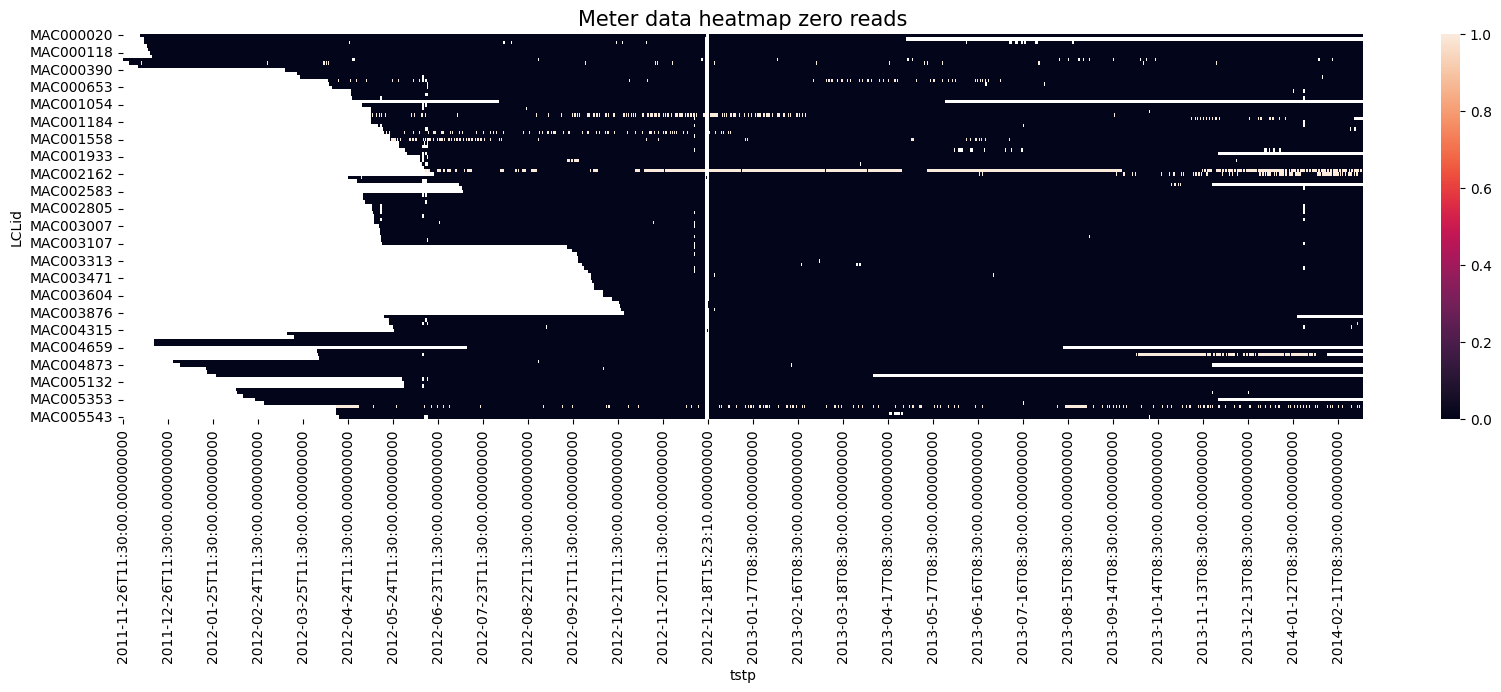

In [27]:
# visualize zeros in the dataset
start_time = time.time()
sample = d[d['LCLid'].isin(sampleMeters)]
sample['ZerokWhPerHalfHour'] = sample['kWhPerHalfHour'] == 0
pivot_table = pd.pivot_table(sample, columns='tstp', index='LCLid', values='ZerokWhPerHalfHour')
print('%s seconds' % (time.time() - start_time))
plt.subplots(figsize=(20,5))
sns.heatmap(pivot_table, xticklabels=48*30)
plt.title('Meter data heatmap zero reads', size=15)
plt.savefig('meter data heatmap zeros.png', format='png')

In [28]:
start_time = time.time()
d.to_csv('/kaggle/working/MeterDataFinal.csv',index=False)
print('%s seconds' % (time.time() - start_time))

448.69399762153625 seconds


In [29]:
sampleMetersWithZeroReads = sample[sample['kWhPerHalfHour'] == 0].groupby('LCLid').agg('count')
sampleMetersWithZeroReads

tstp  kWhPerHalfHour  ZerokWhPerHalfHour
LCLid                                               
MAC000133      5               5                   5
MAC000214    684             684                 684
MAC000390      4               4                   4
MAC000549   1180            1180                1180
MAC000653      1               1                   1
MAC001159      3               3                   3
MAC001170   3825            3825                3825
MAC001180    704             704                 704
MAC001413   2502            2502                2502
MAC001558   1941            1941                1941
MAC001933      5               5                   5
MAC001938    303             303                 303
MAC001982      1               1                   1
MAC002050  19771           19771               19771
MAC002162   2812            2812                2812
MAC002320     19              19                  19
MAC002510    135             135                 135
MAC002805      3               3                   3
MAC002866     23              23                  23
MAC003040      3               3                   3
MAC003085     11              11                  11
MAC003274      1               1                   1
MAC003486      4               4                   4
MAC003789      2               2                   2
MAC003837      4               4                   4
MAC004157      2               2                   2
MAC004190     88              88                  88
MAC004271     43              43                  43
MAC004460      1               1                   1
MAC004803   4939            4939                4939
MAC004927     14              14                  14
MAC005445   5315            5315                5315
MAC005543      4               4                   4

               LCLid                tstp kWhPerHalfHour  ZerokWhPerHalfHour
107809276  MAC002050 2012-06-15 00:30:00            0.0                True
107809277  MAC002050 2012-06-15 01:00:00            0.0                True
107809278  MAC002050 2012-06-15 01:30:00            0.0                True
107809279  MAC002050 2012-06-15 02:00:00            0.0                True
107809280  MAC002050 2012-06-15 02:30:00            0.0                True
...              ...                 ...            ...                 ...
107839127  MAC002050 2014-02-27 22:00:00            0.0                True
107839128  MAC002050 2014-02-27 22:30:00            0.0                True
107839129  MAC002050 2014-02-27 23:00:00            0.0                True
107839130  MAC002050 2014-02-27 23:30:00            0.0                True
107839131  MAC002050 2014-02-28 00:00:00            0.0                True

[29856 rows x 4 columns]


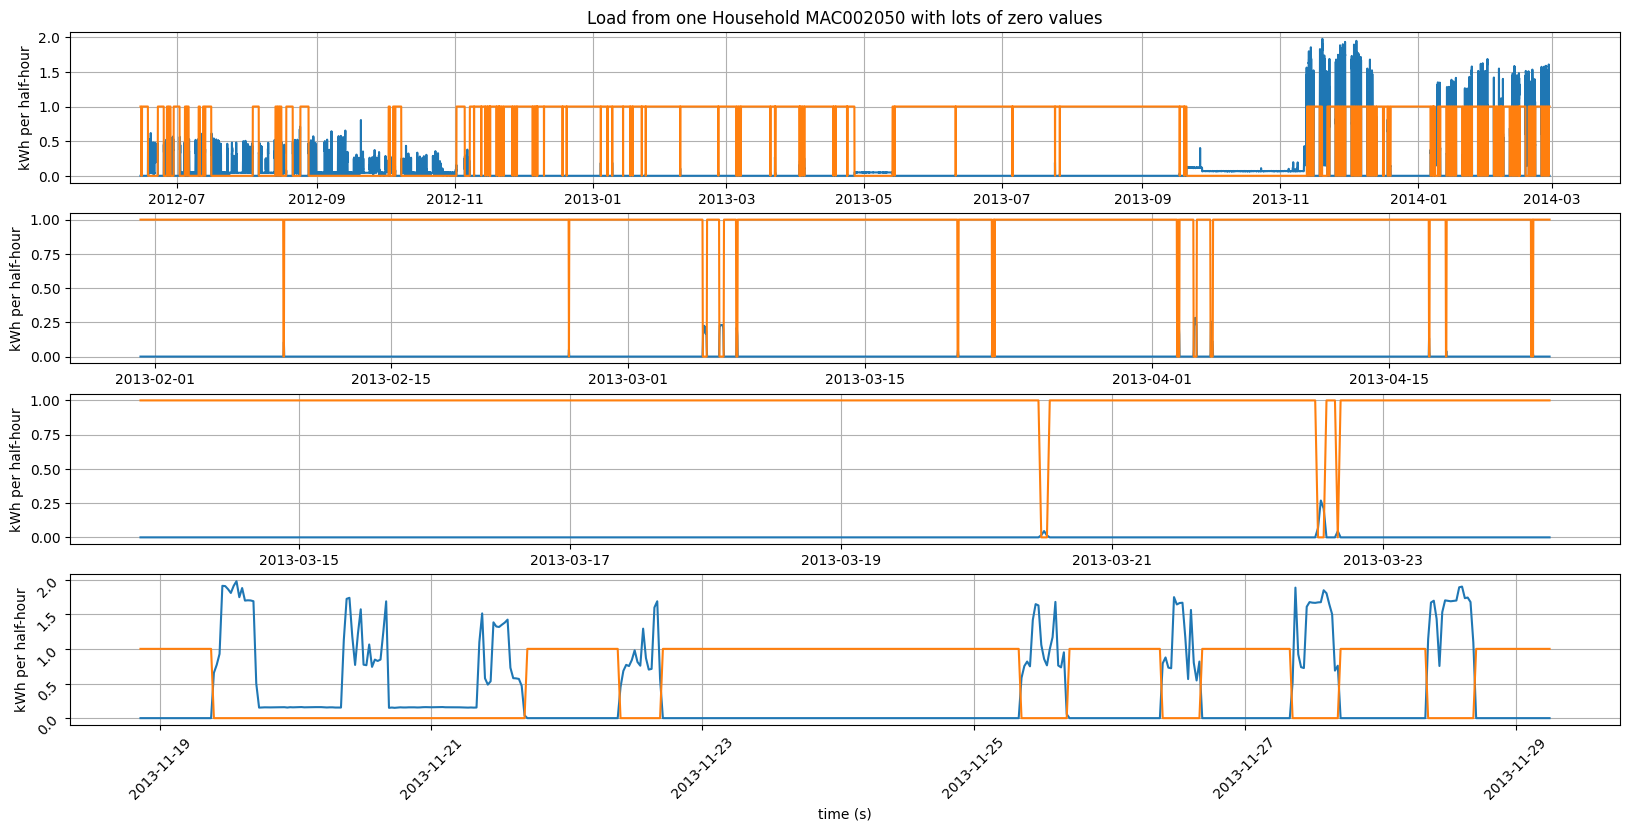

In [30]:
# investigate the meters with zero reads
MAC002050 = sample.query("LCLid == 'MAC002050'")
print(MAC002050)
fig, ax = plt.subplots(4,figsize=(20,9))

# plot whole ~2 years
ax[0].plot(MAC002050.tstp, MAC002050.kWhPerHalfHour)
ax[0].plot(MAC002050.tstp, MAC002050.ZerokWhPerHalfHour)
ax[0].set(ylabel='kWh per half-hour',
       title='Load from one Household MAC002050 with lots of zero values')
plt.tick_params(rotation=45)
ax[0].grid()

# zoom in
ax[1].plot(MAC002050.tstp[11000:15000], MAC002050.kWhPerHalfHour[11000:15000])
ax[1].plot(MAC002050.tstp[11000:15000], MAC002050.ZerokWhPerHalfHour[11000:15000])
ax[1].set(xlabel='time (s)', ylabel='kWh per half-hour')
plt.tick_params(rotation=45)
ax[1].grid()

# zoom in more...
ax[2].plot(MAC002050.tstp[13000:13500], MAC002050.kWhPerHalfHour[13000:13500])
ax[2].plot(MAC002050.tstp[13000:13500], MAC002050.ZerokWhPerHalfHour[13000:13500])
ax[2].set(xlabel='time (s)', ylabel='kWh per half-hour')
plt.tick_params(rotation=45)
ax[2].grid()

# zoom in to a different part of the series...
ax[3].plot(MAC002050.tstp[25000:25500], MAC002050.kWhPerHalfHour[25000:25500])
ax[3].plot(MAC002050.tstp[25000:25500], MAC002050.ZerokWhPerHalfHour[25000:25500])
ax[3].set(xlabel='time (s)', ylabel='kWh per half-hour')
plt.tick_params(rotation=45)
ax[3].grid()

fig.savefig("MAC002050.png")
plt.show()

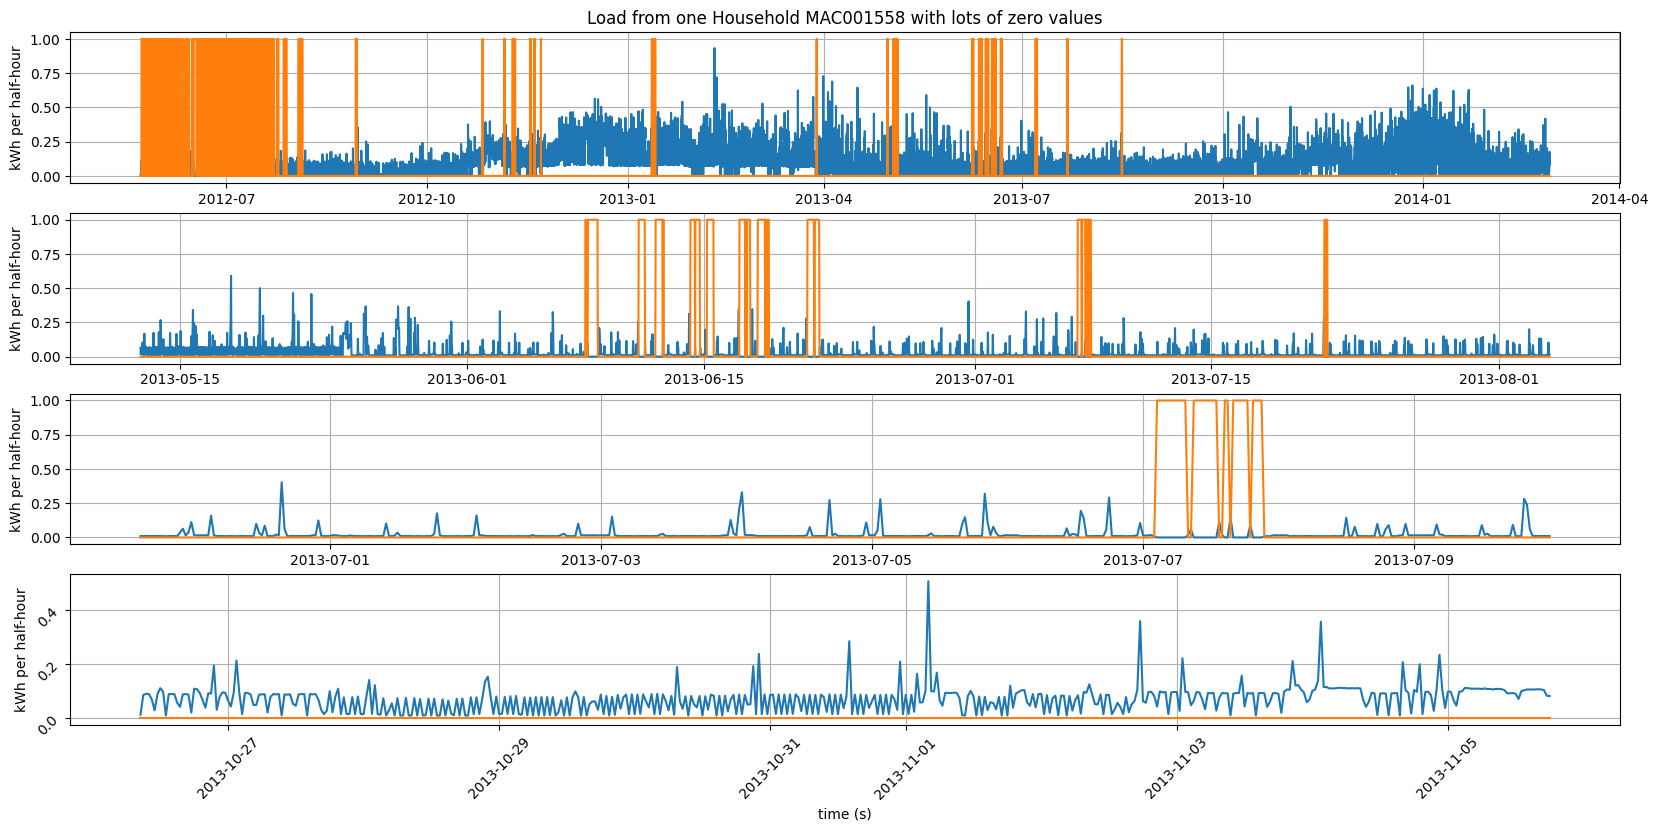

In [31]:
# investigate the meters with zero reads
MAC001558 = sample.query("LCLid == 'MAC001558'")
fig, ax = plt.subplots(4,figsize=(20,9))

# plot whole ~2 years
ax[0].plot(MAC001558.tstp, MAC001558.kWhPerHalfHour)
ax[0].plot(MAC001558.tstp, MAC001558.ZerokWhPerHalfHour)
ax[0].set(ylabel='kWh per half-hour',
       title='Load from one Household MAC001558 with lots of zero values')
plt.tick_params(rotation=45)
ax[0].grid()

# zoom in
ax[1].plot(MAC001558.tstp[17000:21000], MAC001558.kWhPerHalfHour[17000:21000])
ax[1].plot(MAC001558.tstp[17000:21000], MAC001558.ZerokWhPerHalfHour[17000:21000])
ax[1].set(xlabel='time (s)', ylabel='kWh per half-hour')
plt.tick_params(rotation=45)
ax[1].grid()

# zoom in more...
ax[2].plot(MAC001558.tstp[19300:19800], MAC001558.kWhPerHalfHour[19300:19800])
ax[2].plot(MAC001558.tstp[19300:19800], MAC001558.ZerokWhPerHalfHour[19300:19800])
ax[2].set(xlabel='time (s)', ylabel='kWh per half-hour')
plt.tick_params(rotation=45)
ax[2].grid()

# zoom in to a different part of the series...
ax[3].plot(MAC001558.tstp[25000:25500], MAC001558.kWhPerHalfHour[25000:25500])
ax[3].plot(MAC001558.tstp[25000:25500], MAC001558.ZerokWhPerHalfHour[25000:25500])
ax[3].set(xlabel='time (s)', ylabel='kWh per half-hour')
plt.tick_params(rotation=45)
ax[3].grid()

fig.savefig("MAC001558.png")
plt.show()

In [32]:
# explore some basic stats for each house
print(d.groupby('LCLid').max().sort_values('tstp'))
print(d.groupby('LCLid').min().sort_values('tstp'))
print(d.groupby('LCLid').count().sort_values('tstp'))

print(d.groupby('LCLid').agg(['min', 'max', 'count']))

                         tstp kWhPerHalfHour
LCLid                                       
MAC003935 2012-11-06 23:30:00          1.312
MAC005274 2012-11-21 23:30:00          1.628
MAC004364 2012-11-21 23:30:00          2.146
MAC004679 2012-12-01 23:30:00          3.518
MAC002409 2012-12-01 23:30:00          1.527
...                       ...            ...
MAC001977 2014-02-28 00:00:00          1.368
MAC001976 2014-02-28 00:00:00          2.751
MAC001975 2014-02-28 00:00:00          2.096
MAC001994 2014-02-28 00:00:00          3.466
MAC005567 2014-02-28 00:00:00          1.528

[5566 rows x 2 columns]
                         tstp kWhPerHalfHour
LCLid                                       
MAC000145 2011-11-23 09:00:00          0.024
MAC000146 2011-11-23 09:00:00          0.031
MAC000147 2011-11-23 10:00:00          0.008
MAC000148 2011-11-23 10:00:00            0.0
MAC000149 2011-11-23 10:00:00            0.0
...                       ...            ...
MAC004069 2013-07-04 00:30:00 

In [33]:
sample.set_index('tstp')

LCLid kWhPerHalfHour  ZerokWhPerHalfHour
tstp                                                             
2012-05-17 11:00:00  MAC001330          0.157               False
2012-05-17 11:30:00  MAC001330          0.192               False
2012-05-17 12:00:00  MAC001330          0.675               False
2012-05-17 12:30:00  MAC001330          0.418               False
2012-05-17 13:00:00  MAC001330          1.446               False
...                        ...            ...                 ...
2014-02-27 22:00:00  MAC005448          0.144               False
2014-02-27 22:30:00  MAC005448          0.086               False
2014-02-27 23:00:00  MAC005448          0.053               False
2014-02-27 23:30:00  MAC005448          0.058               False
2014-02-28 00:00:00  MAC005448          0.048               False

[3410964 rows x 3 columns]

65.24971032142639 seconds
64.09751605987549 seconds


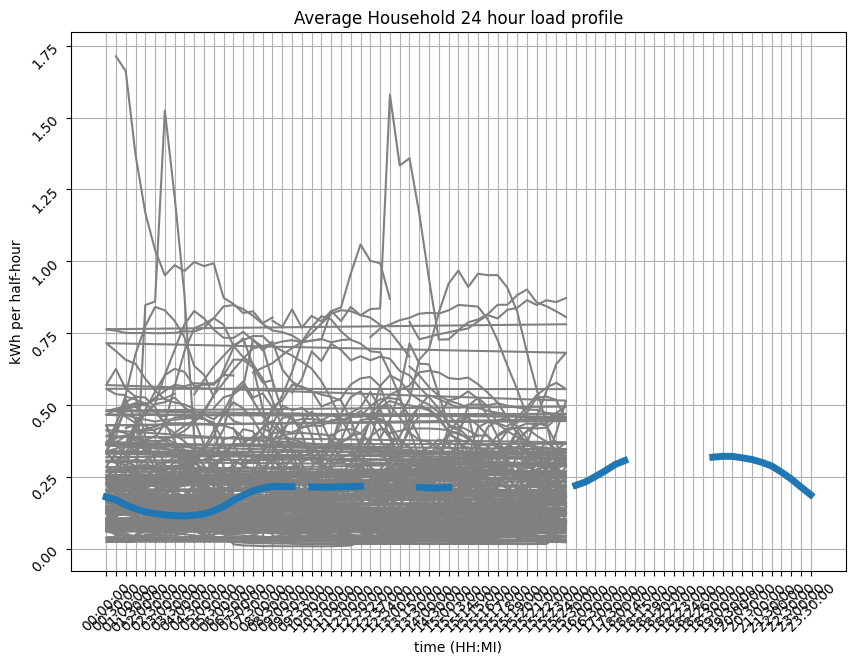

In [34]:
start_time = time.time()
avgLoadProfile = pd.DataFrame(d.groupby([d['tstp'].dt.hour, d['tstp'].dt.minute]).kWhPerHalfHour.mean())
avgLoadProfile = avgLoadProfile.reset_index(names=['hour', 'minute'])
avgLoadProfile['labels'] = pd.to_datetime(avgLoadProfile['hour'].astype(str) + ':' + avgLoadProfile['minute'].astype(str), format='%H:%M').dt.time
print('%s seconds' % (time.time() - start_time))

fig, ax = plt.subplots(figsize=(10,7))

ax.set_xticks(avgLoadProfile.index, avgLoadProfile.labels)

ax.set(xlabel='time (HH:MI)', ylabel='kWh per half-hour',
       title='Average Household 24 hour load profile')

# calculate average daily load for each meter...
start_time = time.time()
avgLoadProfileEachMeter = pd.DataFrame(d.groupby(['LCLid', d['tstp'].dt.hour, d['tstp'].dt.minute]).agg({'kWhPerHalfHour': 'mean'}))
avgLoadProfileEachMeter = avgLoadProfileEachMeter.reset_index(names=['LCLid', 'hour', 'minute'])
print('%s seconds' % (time.time() - start_time))
# print(avgLoadProfileEachMeter.info())
# print(avgLoadProfileEachMeter)

# plot every sample meter
for meter in sampleMeters:
    # print(meter)
    ax.plot(avgLoadProfileEachMeter.loc[avgLoadProfileEachMeter['LCLid'] == meter].index % 48, 
            avgLoadProfileEachMeter.loc[avgLoadProfileEachMeter['LCLid'] == meter].kWhPerHalfHour,
           color='grey')

# plot the average
ax.plot(avgLoadProfile.index, avgLoadProfile.kWhPerHalfHour, linewidth=5)

plt.tick_params(rotation=45)
ax.grid()

fig.savefig("Avg 24hr Load Profile every meter.png")
plt.show()

In [208]:
# Calculate the sum of all loads and count of smart meters for each timestamp
start_time = time.time()
aggLoad = pd.DataFrame(d.groupby('tstp')['kWhPerHalfHour'].agg({'sum', 'count'}))
aggLoad.reset_index(inplace=True)
aggLoad.columns = ['tstp', 'AggregateLoad', 'numMeters']
print('%s seconds' % (time.time() - start_time))

print(aggLoad)
print(aggLoad.describe())
print(aggLoad.info())

18.207808017730713 seconds
                     tstp AggregateLoad  numMeters
0     2011-11-23 09:00:00         0.569          2
1     2011-11-23 09:30:00         0.561          2
2     2011-11-23 10:00:00          0.92          6
3     2011-11-23 10:30:00         0.588          6
4     2011-11-23 11:00:00         0.772          7
...                   ...           ...        ...
40400 2014-02-27 22:00:00      1494.603       4986
40401 2014-02-27 22:30:00   1422.109001       4987
40402 2014-02-27 23:00:00       1258.09       4987
40403 2014-02-27 23:30:00   1073.622001       4987
40404 2014-02-28 00:00:00      1042.266       4987

[40405 rows x 3 columns]
                                tstp     numMeters
count                          40405  40405.000000
mean   2013-01-09 20:23:25.816384256   4153.235020
min              2011-11-23 09:00:00      0.000000
25%              2012-06-20 19:30:00   3735.000000
50%              2013-01-03 08:00:00   5120.000000
75%              2013-08-01 1

In [209]:
aggLoad.sort_values(by=['tstp'], inplace=True)
aggLoad.set_index('tstp', inplace=True)
aggLoad.index.rename('DateTimeIndex', inplace=True)
aggLoad.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 40405 entries, 2011-11-23 09:00:00 to 2014-02-28 00:00:00
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   AggregateLoad  40405 non-null  object
 1   numMeters      40405 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 947.0+ KB


In [210]:
aggLoad['DateTime'] = aggLoad.index
aggLoad.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 40405 entries, 2011-11-23 09:00:00 to 2014-02-28 00:00:00
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   AggregateLoad  40405 non-null  object        
 1   numMeters      40405 non-null  int64         
 2   DateTime       40405 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.2+ MB


In [211]:
AggZeros = aggLoad.query("AggregateLoad == 0")
AggZeros

AggregateLoad  numMeters            DateTime
DateTimeIndex                                                   
2012-12-18 15:13:26             0          0 2012-12-18 15:13:26
2012-12-18 15:13:27             0          0 2012-12-18 15:13:27
2012-12-18 15:13:28             0          0 2012-12-18 15:13:28
2012-12-18 15:13:29             0          0 2012-12-18 15:13:29
2012-12-18 15:13:30             0          0 2012-12-18 15:13:30
...                           ...        ...                 ...
2013-07-05 12:54:31             0          0 2013-07-05 12:54:31
2013-07-05 13:15:05             0          0 2013-07-05 13:15:05
2013-09-20 18:24:09             0          0 2013-09-20 18:24:09
2013-10-29 09:33:01             0          0 2013-10-29 09:33:01
2013-10-29 18:23:02             0          0 2013-10-29 18:23:02

[678 rows x 3 columns]

In [212]:
#inspect and fix records not exactly on the half-hour
offRecs = aggLoad.query("DateTime.dt.minute not in (0,30) or DateTime.dt.second != 0")
print('Records not exactly on the half-hour: ', offRecs)
print(offRecs.info())

# delete records not exactly on the half-hour
aggLoad = aggLoad.drop(offRecs.index)

offRecs = aggLoad.query("DateTime.dt.minute not in (0,30) or DateTime.dt.second != 0")
print('Records not exactly on the half-hour: ', offRecs)

Records not exactly on the half-hour:                      AggregateLoad  numMeters            DateTime
DateTimeIndex                                                   
2012-12-18 15:13:26             0          0 2012-12-18 15:13:26
2012-12-18 15:13:27             0          0 2012-12-18 15:13:27
2012-12-18 15:13:28             0          0 2012-12-18 15:13:28
2012-12-18 15:13:29             0          0 2012-12-18 15:13:29
2012-12-18 15:13:30             0          0 2012-12-18 15:13:30
...                           ...        ...                 ...
2013-07-05 12:54:31             0          0 2013-07-05 12:54:31
2013-07-05 13:15:05             0          0 2013-07-05 13:15:05
2013-09-20 18:24:09             0          0 2013-09-20 18:24:09
2013-10-29 09:33:01             0          0 2013-10-29 09:33:01
2013-10-29 18:23:02             0          0 2013-10-29 18:23:02

[678 rows x 3 columns]
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 678 entries, 2012-12-18 15:13:26 to 201

In [213]:
# check the regularity of the observations (time between observations)
# print(pd.infer_freq(train_data.DateTime))
aggLoad.index.to_series().diff().value_counts()


DateTimeIndex
0 days 00:30:00    39726
Name: count, dtype: int64

In [214]:
# Calculate moving average and stddev for the aggregated load across all meters
window_size = int(len(aggLoad.AggregateLoad) / 10)
print(window_size)

aggLoadMovingStdev = aggLoad.AggregateLoad.rolling(window_size).std()
aggLoadMovingStdev.columns = ['MovingStdev']

aggLoadMovingAvg = aggLoad.AggregateLoad.rolling(window_size).mean()
aggLoadMovingAvg.columns = ['MovingAvg']

print('aggLoadMovingStdev:\n', aggLoadMovingStdev)
print(aggLoadMovingStdev.info())
print('aggLoadMovingAvg:\n', aggLoadMovingAvg)
print(aggLoadMovingAvg.info())

3972
aggLoadMovingStdev:
 DateTimeIndex
2011-11-23 09:00:00           NaN
2011-11-23 09:30:00           NaN
2011-11-23 10:00:00           NaN
2011-11-23 10:30:00           NaN
2011-11-23 11:00:00           NaN
                          ...    
2014-02-27 22:00:00    400.017632
2014-02-27 22:30:00    399.927911
2014-02-27 23:00:00    399.827879
2014-02-27 23:30:00    399.744615
2014-02-28 00:00:00    399.671984
Name: AggregateLoad, Length: 39727, dtype: float64
<class 'pandas.core.series.Series'>
DatetimeIndex: 39727 entries, 2011-11-23 09:00:00 to 2014-02-28 00:00:00
Series name: AggregateLoad
Non-Null Count  Dtype  
--------------  -----  
35756 non-null  float64
dtypes: float64(1)
memory usage: 620.7 KB
None
aggLoadMovingAvg:
 DateTimeIndex
2011-11-23 09:00:00            NaN
2011-11-23 09:30:00            NaN
2011-11-23 10:00:00            NaN
2011-11-23 10:30:00            NaN
2011-11-23 11:00:00            NaN
                          ...     
2014-02-27 22:00:00    1212.687343
20

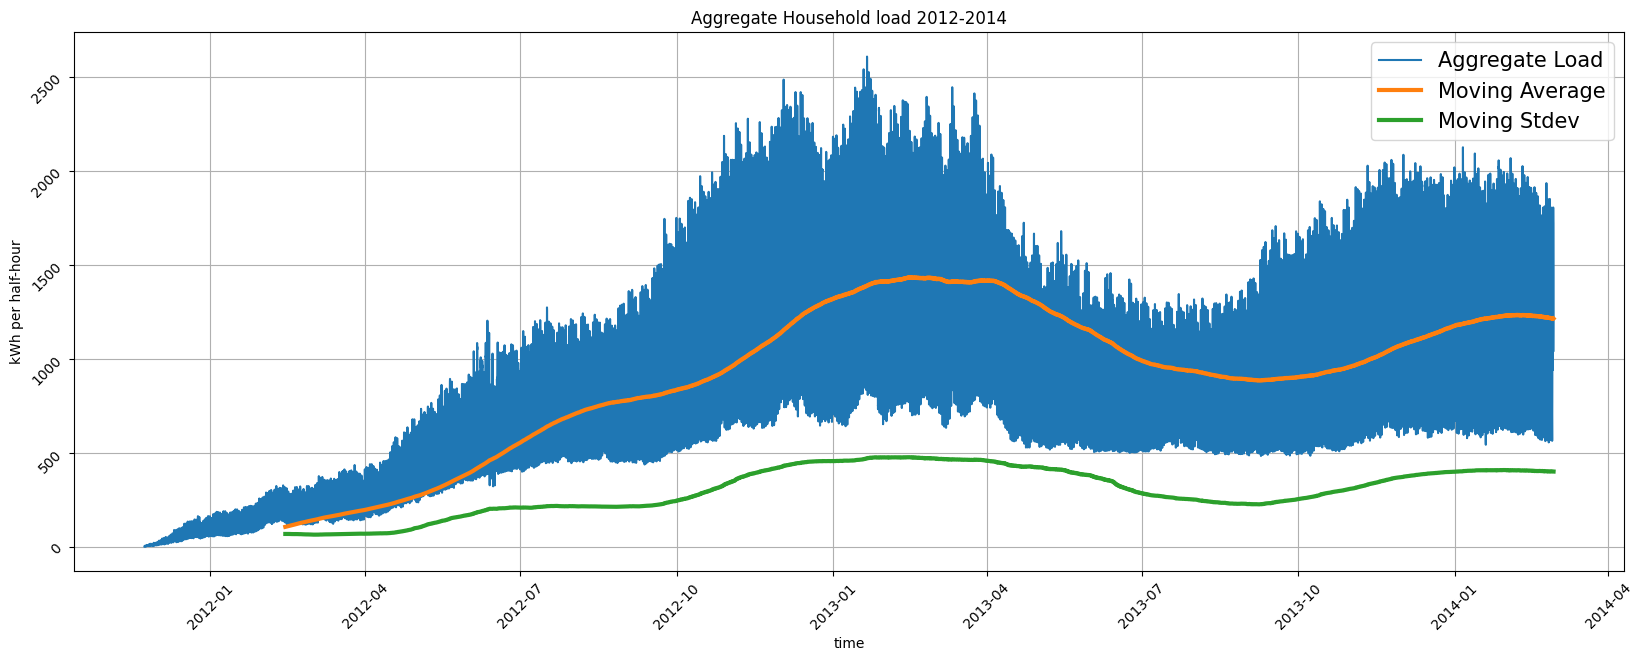

In [215]:
# Visualize aggregate load, moving average, moving standard deviation
# print(aggLoad)
fig, ax = plt.subplots(figsize=(20,7))
ax.plot(aggLoad.DateTime, aggLoad.AggregateLoad, label="Aggregate Load")
ax.plot(aggLoad.DateTime, aggLoadMovingAvg, linewidth=3, label="Moving Average")
ax.plot(aggLoad.DateTime, aggLoadMovingStdev, linewidth=3, label="Moving Stdev")

ax.set(xlabel='time', ylabel='kWh per half-hour',
       title='Aggregate Household load 2012-2014')
plt.tick_params(rotation=45)
ax.grid()

plt.legend(fontsize=15)
fig.savefig("Aggregate Household load 2012-2014.png")
plt.show()

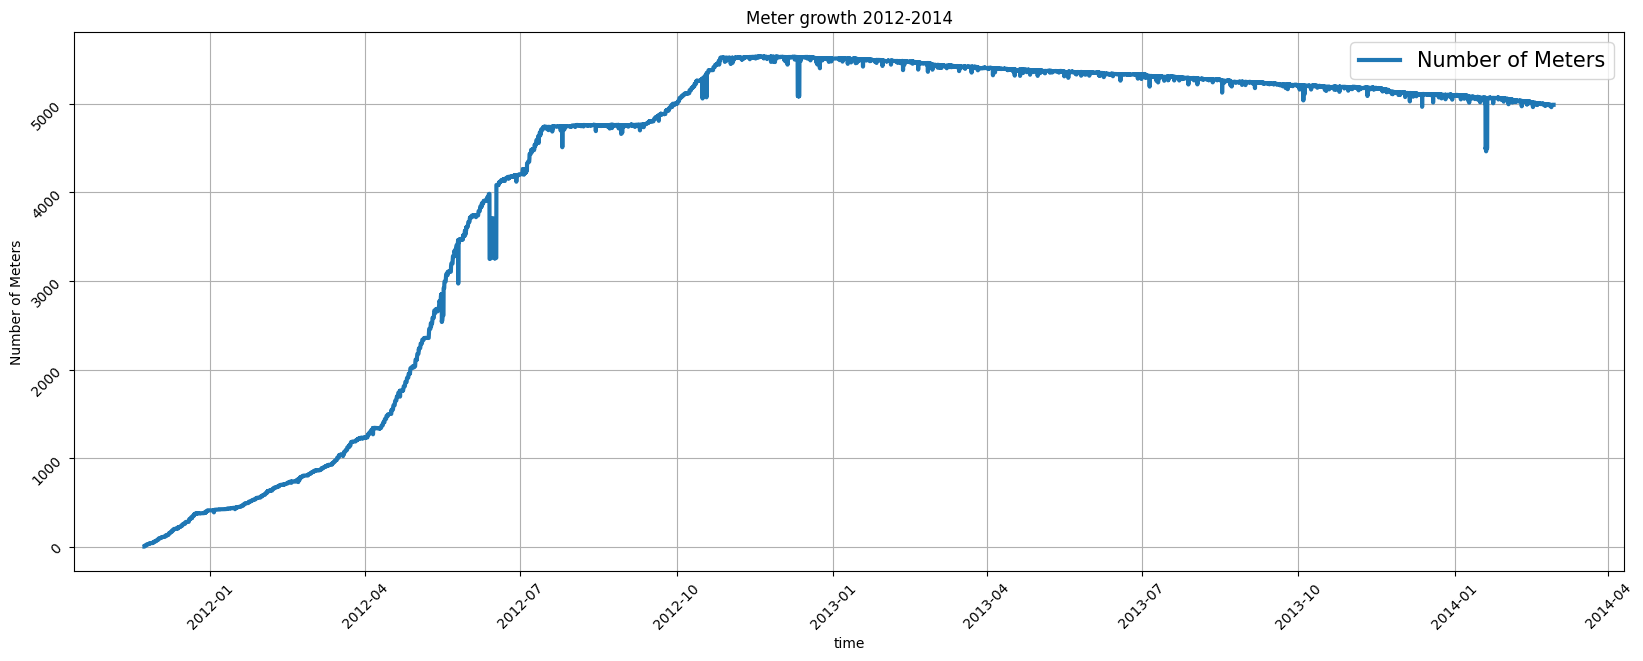

In [216]:
# Show curve of number of meters contributing to the aggregate load
# This shows correlation of increased load with meters being added to the program during the recruitment period 
# print(aggLoad)
fig, ax = plt.subplots(figsize=(20,7))
ax.plot(aggLoad.DateTime, aggLoad.numMeters, linewidth=3, label="Number of Meters")

ax.set(xlabel='time', ylabel='Number of Meters',
       title='Meter growth 2012-2014')
plt.tick_params(rotation=45)
ax.grid()

fig.savefig("Meter growth 2012-2014.png")
plt.legend(fontsize=15)
plt.show()

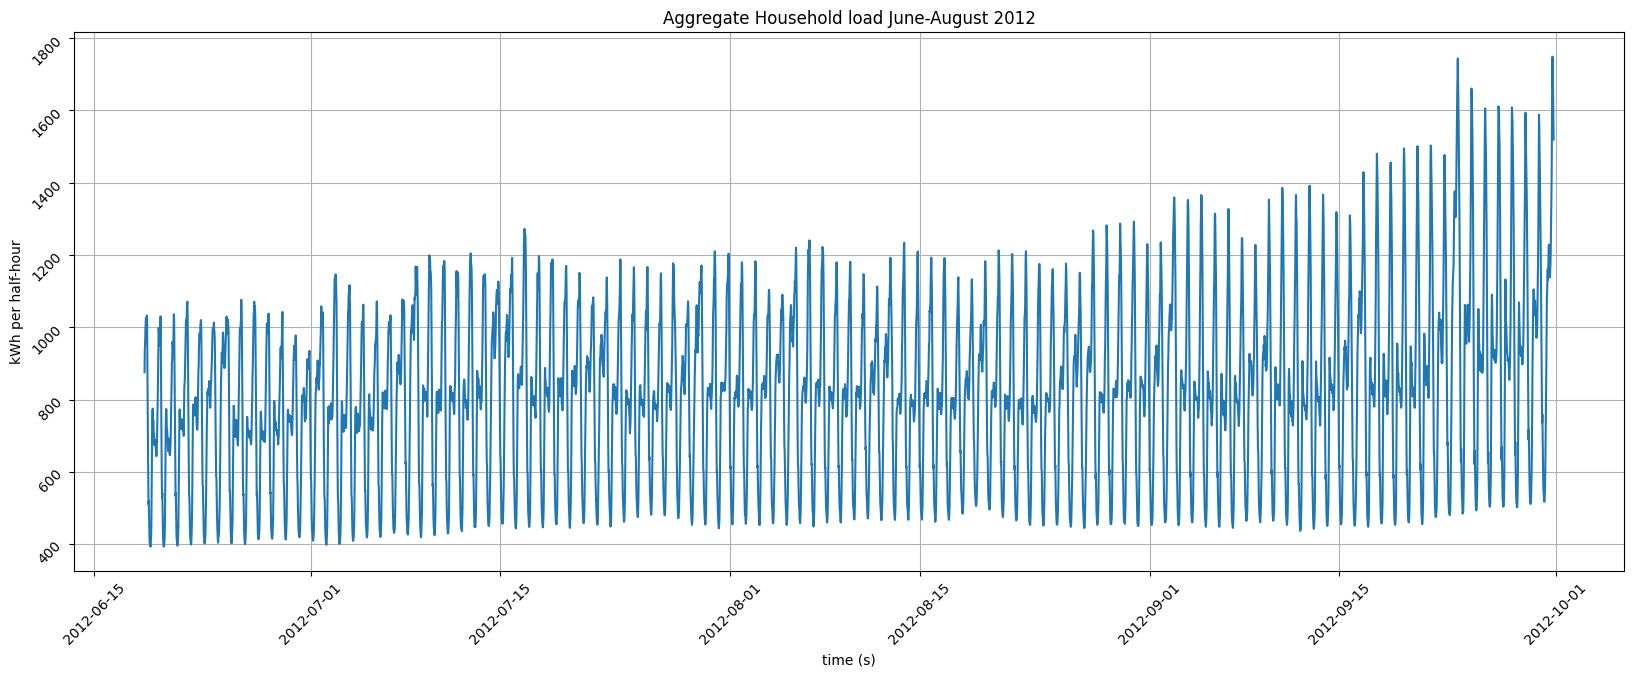

In [217]:
# Aggregate Household load June-August
fig, ax = plt.subplots(figsize=(20,7))
ax.plot(aggLoad.DateTime[10000:15000], aggLoad.AggregateLoad[10000:15000])

ax.set(xlabel='time (s)', ylabel='kWh per half-hour',
       title='Aggregate Household load June-August 2012')
plt.tick_params(rotation=45)
ax.grid()

fig.savefig("Aggregate Household load June-August 2012.png")
plt.show()

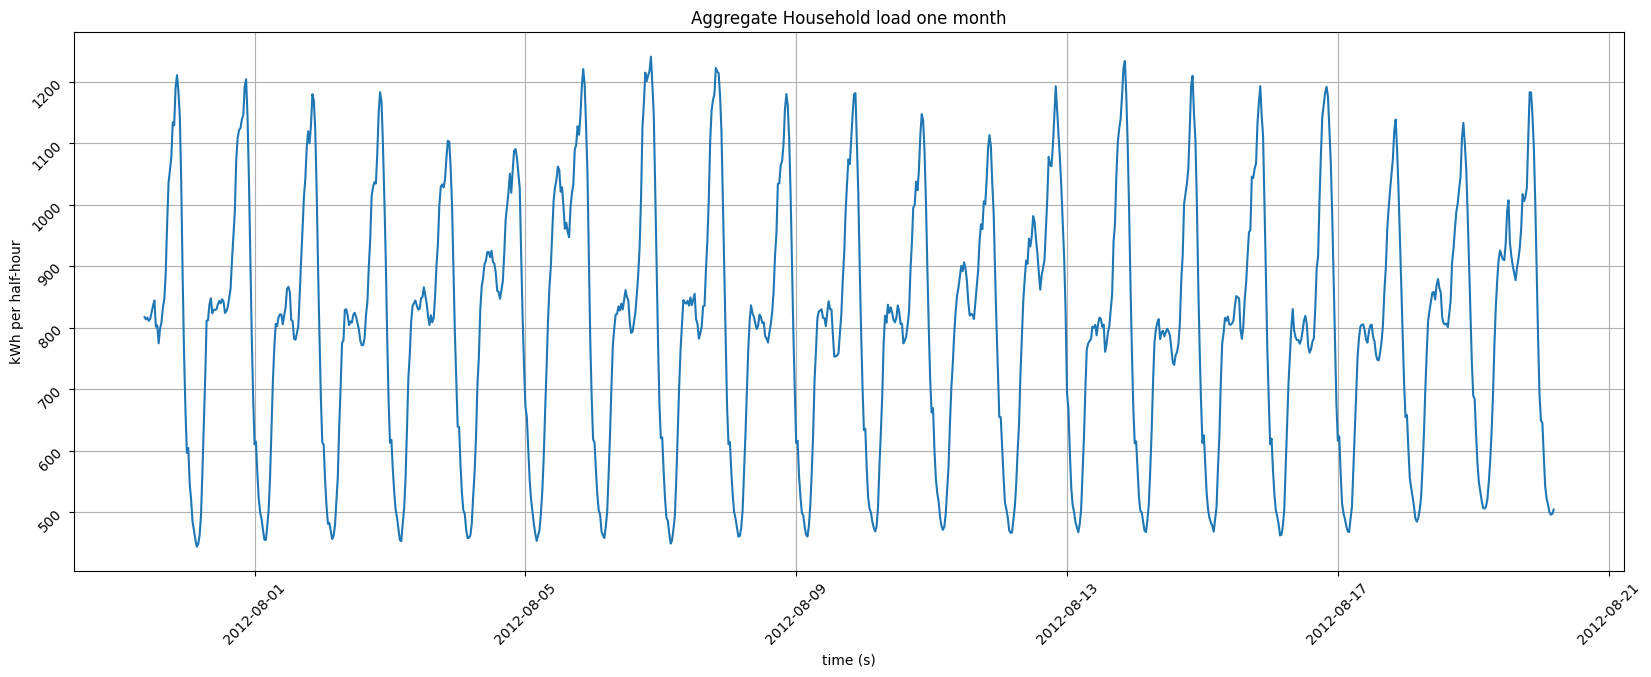

In [218]:
# Aggregate Household load one month
fig, ax = plt.subplots(figsize=(20,7))
ax.plot(aggLoad.DateTime[12000:13000], aggLoad.AggregateLoad[12000:13000])

ax.set(xlabel='time (s)', ylabel='kWh per half-hour',
       title='Aggregate Household load one month')
plt.tick_params(rotation=45)
ax.grid()

fig.savefig("Aggregate Household load one month.png")
plt.show()

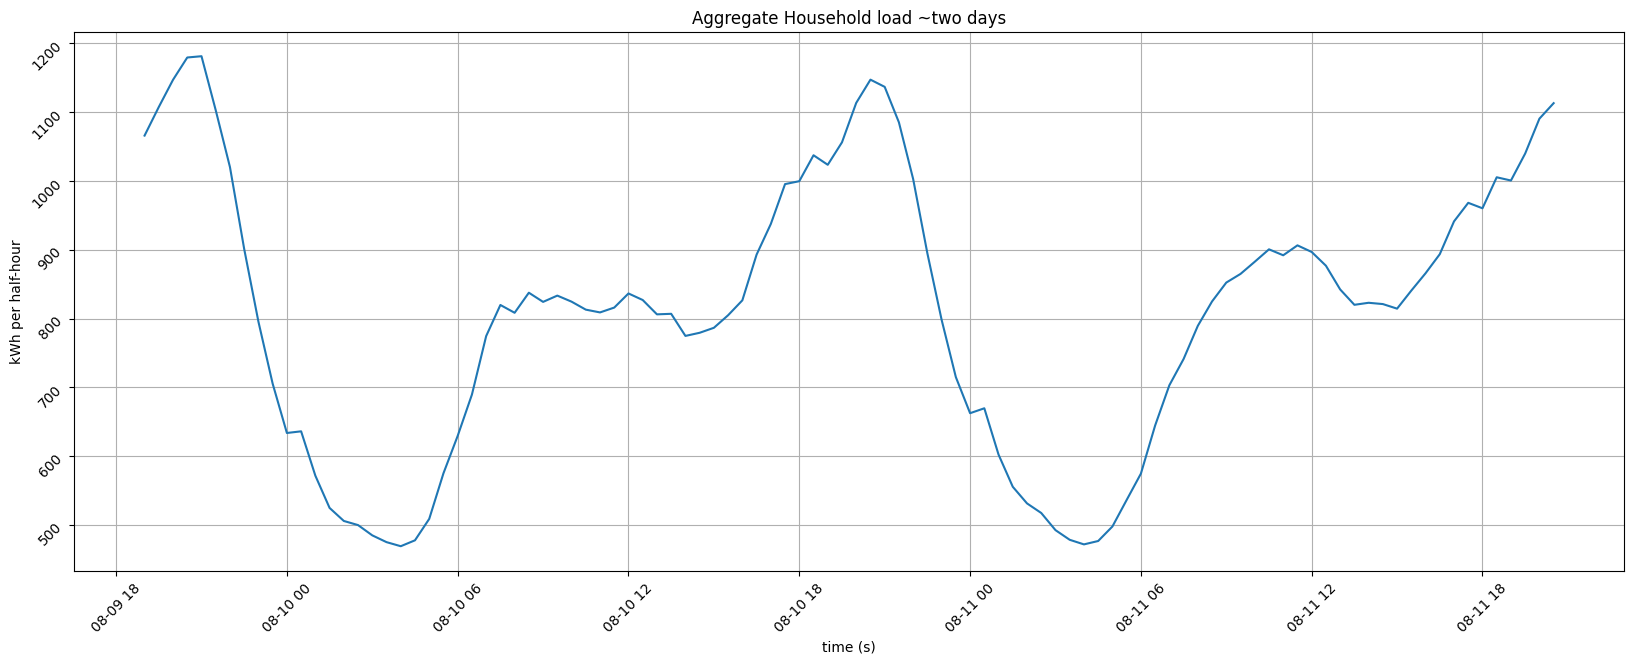

In [219]:
# Aggregate Household load ~two days
fig, ax = plt.subplots(figsize=(20,7))
ax.plot(aggLoad.DateTime[12500:12600], aggLoad.AggregateLoad[12500:12600])

ax.set(xlabel='time (s)', ylabel='kWh per half-hour',
       title='Aggregate Household load ~two days')
plt.tick_params(rotation=45)
ax.grid()

fig.savefig("Aggregate Household load two days.png")
plt.show()

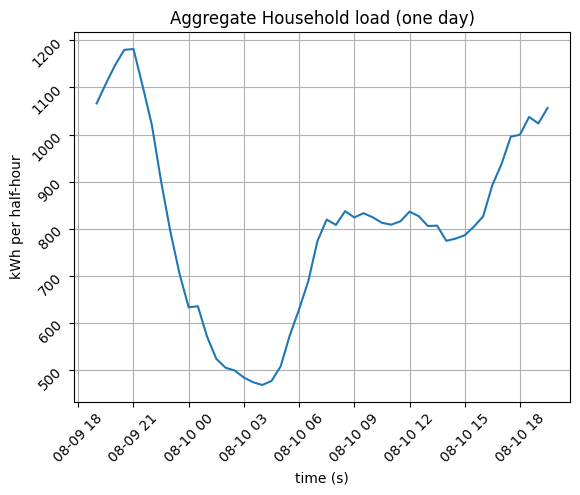

In [220]:
# Aggregate Household load (one day)
fig, ax = plt.subplots()
ax.plot(aggLoad.DateTime[12500:12550], aggLoad.AggregateLoad[12500:12550])

ax.set(xlabel='time (s)', ylabel='kWh per half-hour',
       title='Aggregate Household load (one day)')
plt.tick_params(rotation=45)
ax.grid()

fig.savefig("Aggregate Household load (one day).png")
plt.show()

In [221]:
aggLoad.to_csv('/kaggle/working/aggLoadDataFinal.csv',index=False)

In [222]:
aggLoad = pd.read_csv('/kaggle/working/aggLoadDataFinal.csv', parse_dates=["DateTime"])
aggLoad

AggregateLoad  numMeters            DateTime
0           0.569000          2 2011-11-23 09:00:00
1           0.561000          2 2011-11-23 09:30:00
2           0.920000          6 2011-11-23 10:00:00
3           0.588000          6 2011-11-23 10:30:00
4           0.772000          7 2011-11-23 11:00:00
...              ...        ...                 ...
39722    1494.603000       4986 2014-02-27 22:00:00
39723    1422.109001       4987 2014-02-27 22:30:00
39724    1258.090000       4987 2014-02-27 23:00:00
39725    1073.622001       4987 2014-02-27 23:30:00
39726    1042.266000       4987 2014-02-28 00:00:00

[39727 rows x 3 columns]

In [223]:
aggLoad.iloc[35299]

AggregateLoad               1834.417
numMeters                       5125
DateTime         2013-11-27 18:30:00
Name: 35299, dtype: object

In [224]:
# Join load data and weather data
mergeData = pd.merge(aggLoad, weatherUpsample, on='DateTime', copy=False)
print(mergeData.info())
mergeData

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39727 entries, 0 to 39726
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   AggregateLoad  39727 non-null  float64       
 1   numMeters      39727 non-null  int64         
 2   DateTime       39727 non-null  datetime64[ns]
 3   temperature    39727 non-null  float64       
 4   dewPoint       39727 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 1.5 MB
None


AggregateLoad  numMeters            DateTime  temperature  dewPoint
0           0.569000          2 2011-11-23 09:00:00        4.840     4.680
1           0.561000          2 2011-11-23 09:30:00        5.290     5.070
2           0.920000          6 2011-11-23 10:00:00        5.740     5.460
3           0.588000          6 2011-11-23 10:30:00        6.705     5.600
4           0.772000          7 2011-11-23 11:00:00        7.670     5.740
...              ...        ...                 ...          ...       ...
39722    1494.603000       4986 2014-02-27 22:00:00        4.100     1.640
39723    1422.109001       4987 2014-02-27 22:30:00        4.015     1.625
39724    1258.090000       4987 2014-02-27 23:00:00        3.930     1.610
39725    1073.622001       4987 2014-02-27 23:30:00        3.870     1.570
39726    1042.266000       4987 2014-02-28 00:00:00        3.810     1.530

[39727 rows x 5 columns]

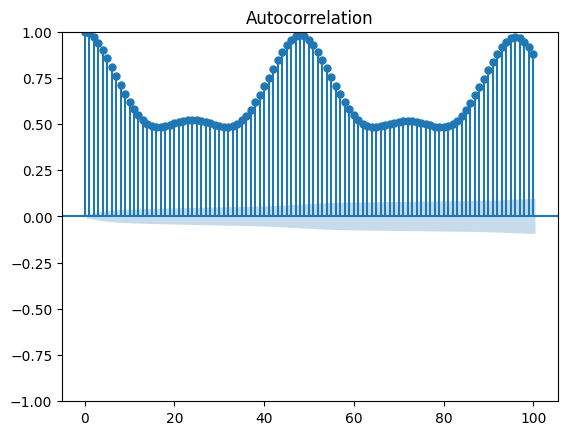

In [225]:
from statsmodels.graphics.tsaplots import plot_acf

# Extract the AggregateLoad feature
aggregate_load = mergeData['AggregateLoad']

# Plot the autocorrelation plot
plot_acf(aggregate_load, lags=100)

# Show the plot
plt.show()

In [226]:
mergeData["DateTime"] = pd.to_datetime(mergeData["DateTime"])

# Cyclical features
# Week of the year using isocalendar()
weekOfYear = mergeData.DateTime.dt.isocalendar().week  # Use isocalendar().week
mergeData["weekOfYear_sin"] = np.sin(weekOfYear * (2. * np.pi / 52))
mergeData["weekOfYear_cos"] = np.cos(weekOfYear * (2. * np.pi / 52))

# Day of the week
dayOfWeek = mergeData.DateTime.dt.dayofweek
mergeData["dayOfWeek_sin"] = np.sin(dayOfWeek * (2. * np.pi / 7))
mergeData["dayOfWeek_cos"] = np.cos(dayOfWeek * (2. * np.pi / 7))

# Minute of the day
minuteOfDay = (mergeData.DateTime.dt.hour * 60) + mergeData.DateTime.dt.minute
mergeData["minuteOfDay_sin"] = np.sin(minuteOfDay * (2. * np.pi / 1440))  # Corrected to 1440 minutes in a day
mergeData["minuteOfDay_cos"] = np.cos(minuteOfDay * (2. * np.pi / 1440))

In [227]:
decomp_df = pd.DataFrame(mergeData.copy())
decomp_df = decomp_df.set_index(pd.DatetimeIndex(decomp_df['DateTime']))
decomp_df.index=decomp_df.DateTime
decomp_df = decomp_df.AggregateLoad
print(decomp_df.describe())
print(decomp_df.info)

count    39727.000000
mean       894.601236
std        517.948065
min          0.561000
25%        531.408000
50%        874.417000
75%       1220.017000
max       2606.830999
Name: AggregateLoad, dtype: float64
<bound method Series.info of DateTime
2011-11-23 09:00:00       0.569000
2011-11-23 09:30:00       0.561000
2011-11-23 10:00:00       0.920000
2011-11-23 10:30:00       0.588000
2011-11-23 11:00:00       0.772000
                          ...     
2014-02-27 22:00:00    1494.603000
2014-02-27 22:30:00    1422.109001
2014-02-27 23:00:00    1258.090000
2014-02-27 23:30:00    1073.622001
2014-02-28 00:00:00    1042.266000
Name: AggregateLoad, Length: 39727, dtype: float64>


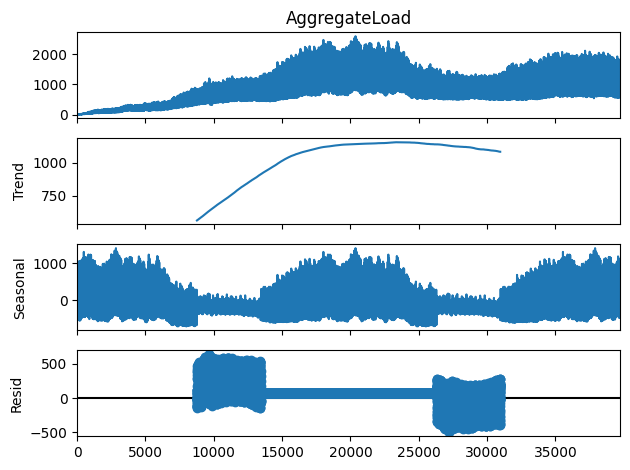

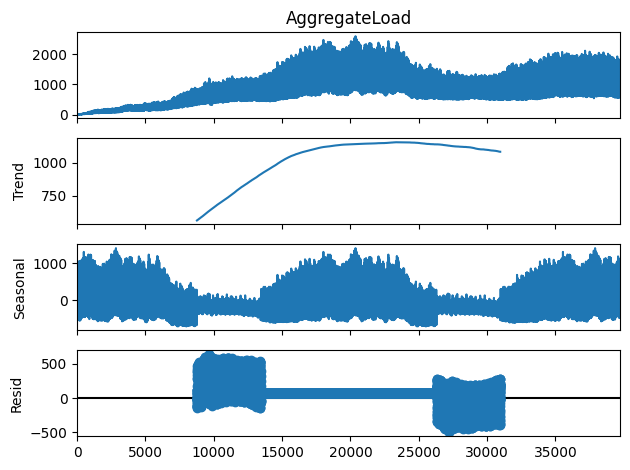

In [228]:
# Annual decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
yearly_seasonal_decomp = seasonal_decompose(mergeData['AggregateLoad'], period=17532)
mergeData['yearlySeasonal']=yearly_seasonal_decomp.seasonal
yearly_seasonal_decomp.plot()

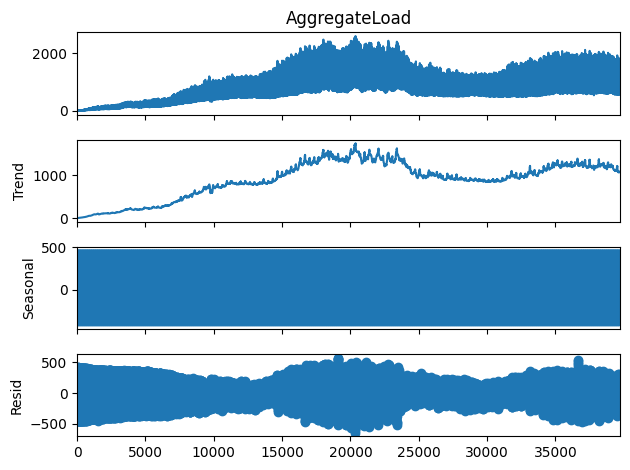

In [229]:
# daily decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
daily_seasonal_decomp = seasonal_decompose(mergeData['AggregateLoad'], period=48)
mergeData['dailyTrend']=daily_seasonal_decomp.trend
mergeData['dailySeasonal']=daily_seasonal_decomp.seasonal
mergeData['dailyResid']=daily_seasonal_decomp.resid
daily_seasonal_decomp.plot();

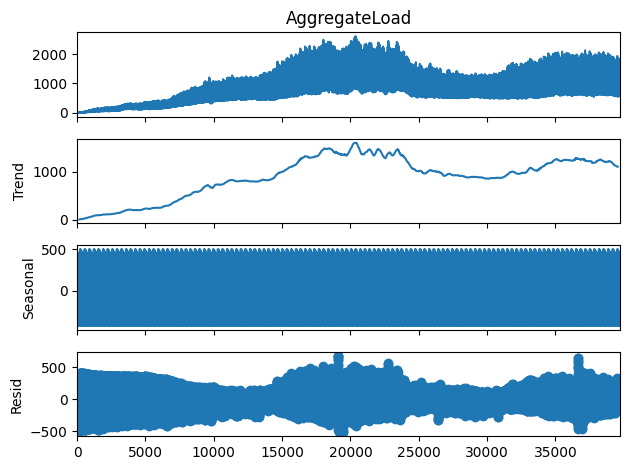

In [230]:
# weekly decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
weekly_seasonal_decomp = seasonal_decompose(mergeData['AggregateLoad'], period=336)
mergeData['weeklyTrend']=weekly_seasonal_decomp.trend
mergeData['weeklySeasonal']=weekly_seasonal_decomp.seasonal
mergeData['weeklyResid']=weekly_seasonal_decomp.resid
weekly_seasonal_decomp.plot();

In [231]:
# load 1 day lag
oneDayPeriods = 48
mergeData['AggregateLoad_1dayLag'] = mergeData['AggregateLoad'].shift(oneDayPeriods)
# load 1 week lag
oneWeekPeriods = oneDayPeriods * 7
mergeData['AggregateLoad_1weekLag'] = mergeData['AggregateLoad'].shift(oneWeekPeriods)

# load change from last half-hour to this half-hour
mergeData['AggregateLoad_halfhourdiff'] = mergeData['AggregateLoad'] - mergeData['AggregateLoad'].shift(1)
# load change from one week ago to this half-hour
mergeData['AggregateLoad_weekdiff'] = mergeData['AggregateLoad'] - mergeData['AggregateLoad'].shift(oneWeekPeriods)

print(mergeData.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39727 entries, 0 to 39726
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   AggregateLoad               39727 non-null  float64       
 1   numMeters                   39727 non-null  int64         
 2   DateTime                    39727 non-null  datetime64[ns]
 3   temperature                 39727 non-null  float64       
 4   dewPoint                    39727 non-null  float64       
 5   weekOfYear_sin              39727 non-null  Float64       
 6   weekOfYear_cos              39727 non-null  Float64       
 7   dayOfWeek_sin               39727 non-null  float64       
 8   dayOfWeek_cos               39727 non-null  float64       
 9   minuteOfDay_sin             39727 non-null  float64       
 10  minuteOfDay_cos             39727 non-null  float64       
 11  yearlySeasonal              39727 non-null  float64   

In [232]:
# drop NaNs created by feature engineering
mergeData.dropna(inplace=True)

In [233]:
# temperature change from last half-hour to this half-hour
# eliminated due to permutation feature importance
# weatherUpsample['temp_halfhourdiff'] = weatherUpsample['temperature'] - weatherUpsample['temperature'].shift(1)

# max temp for the day
mergeData['temp_daymax'] = mergeData.groupby(mergeData.DateTime.dt.date)['temperature'].transform('max')
mergeData['temp_daymin'] = mergeData.groupby(weatherUpsample.DateTime.dt.date)['temperature'].transform('min')
print(mergeData['temp_daymax'])
print(mergeData['temp_daymin'])

336      11.87
337      11.87
338      11.87
339      11.87
340      11.87
         ...  
39554    13.07
39555    13.07
39556    13.07
39557    13.07
39558    13.07
Name: temp_daymax, Length: 39223, dtype: float64
336      7.66
337      7.66
338      7.66
339      7.66
340      7.66
         ... 
39554    9.22
39555    9.22
39556    9.22
39557    9.22
39558    9.22
Name: temp_daymin, Length: 39223, dtype: float64


In [234]:
# Move first column to the Last
# df = pd.DataFrame(mergeData)
df = mergeData
temp_cols=df.columns.tolist()
new_cols=temp_cols[1:] + temp_cols[0:1]
mergeData=df[new_cols]
print(mergeData)

       numMeters            DateTime  temperature  dewPoint  weekOfYear_sin  \
336           64 2011-11-30 09:00:00        7.660     4.960       -0.464723   
337           66 2011-11-30 09:30:00        8.695     5.475       -0.464723   
338           69 2011-11-30 10:00:00        9.730     5.990       -0.464723   
339           70 2011-11-30 10:30:00       10.510     6.040       -0.464723   
340           68 2011-11-30 11:00:00       11.290     6.090       -0.464723   
...          ...                 ...          ...       ...             ...   
39554       4993 2014-02-24 10:00:00       11.320     6.260        0.885456   
39555       4990 2014-02-24 10:30:00       11.890     6.055        0.885456   
39556       4984 2014-02-24 11:00:00       12.460     5.850        0.885456   
39557       4991 2014-02-24 11:30:00       12.765     6.215        0.885456   
39558       4992 2014-02-24 12:00:00       13.070     6.580        0.885456   

       weekOfYear_cos  dayOfWeek_sin  dayOfWeek_cos

In [162]:
from pandas_profiling import ProfileReport

profile = ProfileReport(mergeData, tsmode=True, sortby="DateTime")
profile.to_file('mergeData profile_report.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [235]:
# Remove the dateTime feature from the dataset (we've extracted to features we need from it)
print(mergeData)
mergeData.drop(columns=['DateTime'], inplace=True)

       numMeters            DateTime  temperature  dewPoint  weekOfYear_sin  \
336           64 2011-11-30 09:00:00        7.660     4.960       -0.464723   
337           66 2011-11-30 09:30:00        8.695     5.475       -0.464723   
338           69 2011-11-30 10:00:00        9.730     5.990       -0.464723   
339           70 2011-11-30 10:30:00       10.510     6.040       -0.464723   
340           68 2011-11-30 11:00:00       11.290     6.090       -0.464723   
...          ...                 ...          ...       ...             ...   
39554       4993 2014-02-24 10:00:00       11.320     6.260        0.885456   
39555       4990 2014-02-24 10:30:00       11.890     6.055        0.885456   
39556       4984 2014-02-24 11:00:00       12.460     5.850        0.885456   
39557       4991 2014-02-24 11:30:00       12.765     6.215        0.885456   
39558       4992 2014-02-24 12:00:00       13.070     6.580        0.885456   

       weekOfYear_cos  dayOfWeek_sin  dayOfWeek_cos

In [236]:
mergeData.to_csv('/kaggle/working/mergeDataFeatureCandidates.csv',index=False)

In [237]:
mergeData = pd.read_csv('/kaggle/working/mergeDataFeatureCandidates.csv')
mergeData

numMeters  temperature  dewPoint  weekOfYear_sin  weekOfYear_cos  \
0             64        7.660     4.960       -0.464723        0.885456   
1             66        8.695     5.475       -0.464723        0.885456   
2             69        9.730     5.990       -0.464723        0.885456   
3             70       10.510     6.040       -0.464723        0.885456   
4             68       11.290     6.090       -0.464723        0.885456   
...          ...          ...       ...             ...             ...   
39218       4993       11.320     6.260        0.885456        0.464723   
39219       4990       11.890     6.055        0.885456        0.464723   
39220       4984       12.460     5.850        0.885456        0.464723   
39221       4991       12.765     6.215        0.885456        0.464723   
39222       4992       13.070     6.580        0.885456        0.464723   

       dayOfWeek_sin  dayOfWeek_cos  minuteOfDay_sin  minuteOfDay_cos  \
0           0.974928      -0.222521     7.071068e-01        -0.707107   
1           0.974928      -0.222521     6.087614e-01        -0.793353   
2           0.974928      -0.222521     5.000000e-01        -0.866025   
3           0.974928      -0.222521     3.826834e-01        -0.923880   
4           0.974928      -0.222521     2.588190e-01        -0.965926   
...              ...            ...              ...              ...   
39218       0.000000       1.000000     5.000000e-01        -0.866025   
39219       0.000000       1.000000     3.826834e-01        -0.923880   
39220       0.000000       1.000000     2.588190e-01        -0.965926   
39221       0.000000       1.000000     1.305262e-01        -0.991445   
39222       0.000000       1.000000     1.224647e-16        -1.000000   

       yearlySeasonal  ...  weeklyTrend  weeklySeasonal  weeklyResid  \
0           44.250592  ...    15.335481       -4.088359    -0.296122   
1           91.951348  ...    15.402359      -18.862282    16.375923   
2          228.643478  ...    15.461938      -33.540041    30.522103   
3          479.352190  ...    15.515085      -42.648619    39.456534   
4          710.197716  ...    15.559677      -45.592347    40.652670   
...               ...  ...          ...             ...          ...   
39218     -404.835424  ...  1101.068327       -8.518354   -53.576974   
39219     -411.885597  ...  1101.155391      -16.066682   -62.703709   
39220     -412.281336  ...  1101.232396      -22.239638   -84.145759   
39221     -388.416590  ...  1101.214432      -17.115740  -107.684691   
39222     -368.722669  ...  1101.109592      -12.873993  -107.311599   

       AggregateLoad_1dayLag  AggregateLoad_1weekLag  \
0                   9.500000                0.569000   
1                   8.304000                0.561000   
2                   9.475000                0.920000   
3                  10.045000                0.588000   
4                   9.096000                0.772000   
...                      ...                     ...   
39218            1261.039999             1165.287000   
39219            1283.036998             1143.727000   
39220            1289.873000             1143.224000   
39221            1342.569001             1139.818999   
39222            1363.870000             1126.252000   

       AggregateLoad_halfhourdiff  AggregateLoad_weekdiff  temp_daymax  \
0                        0.134000               10.382000        11.87   
1                        1.965000               12.355000        11.87   
2                       -0.472000               11.524000        11.87   
3                       -0.121000               11.735000        11.87   
4                       -1.703000                9.848000        11.87   
...                           ...                     ...          ...   
39218                  -26.382000             -126.314000        13.07   
39219                  -16.588000             -121.342000        13.07   
39220                  -2

In [238]:
print(mergeData.columns)

Index(['numMeters', 'temperature', 'dewPoint', 'weekOfYear_sin',
       'weekOfYear_cos', 'dayOfWeek_sin', 'dayOfWeek_cos', 'minuteOfDay_sin',
       'minuteOfDay_cos', 'yearlySeasonal', 'dailyTrend', 'dailySeasonal',
       'dailyResid', 'weeklyTrend', 'weeklySeasonal', 'weeklyResid',
       'AggregateLoad_1dayLag', 'AggregateLoad_1weekLag',
       'AggregateLoad_halfhourdiff', 'AggregateLoad_weekdiff', 'temp_daymax',
       'temp_daymin', 'AggregateLoad'],
      dtype='object')


In [239]:
mergeData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39223 entries, 0 to 39222
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   numMeters                   39223 non-null  int64  
 1   temperature                 39223 non-null  float64
 2   dewPoint                    39223 non-null  float64
 3   weekOfYear_sin              39223 non-null  float64
 4   weekOfYear_cos              39223 non-null  float64
 5   dayOfWeek_sin               39223 non-null  float64
 6   dayOfWeek_cos               39223 non-null  float64
 7   minuteOfDay_sin             39223 non-null  float64
 8   minuteOfDay_cos             39223 non-null  float64
 9   yearlySeasonal              39223 non-null  float64
 10  dailyTrend                  39223 non-null  float64
 11  dailySeasonal               39223 non-null  float64
 12  dailyResid                  39223 non-null  float64
 13  weeklyTrend                 392

In [240]:
# select features
mergeData = mergeData[['weekOfYear_sin', 'weekOfYear_cos', 'dayOfWeek_sin', 'dayOfWeek_cos', 'dailyTrend', 'dailySeasonal', 'dailyResid', 'weeklyTrend', 'weeklySeasonal', 'weeklyResid', 'AggregateLoad_1dayLag', 'AggregateLoad_1weekLag', 'AggregateLoad_halfhourdiff', 'temperature', 'temp_daymax', 'AggregateLoad']]
mergeData.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39223 entries, 0 to 39222
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   weekOfYear_sin              39223 non-null  float64
 1   weekOfYear_cos              39223 non-null  float64
 2   dayOfWeek_sin               39223 non-null  float64
 3   dayOfWeek_cos               39223 non-null  float64
 4   dailyTrend                  39223 non-null  float64
 5   dailySeasonal               39223 non-null  float64
 6   dailyResid                  39223 non-null  float64
 7   weeklyTrend                 39223 non-null  float64
 8   weeklySeasonal              39223 non-null  float64
 9   weeklyResid                 39223 non-null  float64
 10  AggregateLoad_1dayLag       39223 non-null  float64
 11  AggregateLoad_1weekLag      39223 non-null  float64
 12  AggregateLoad_halfhourdiff  39223 non-null  float64
 13  temperature                 392

In [241]:
mergeData.to_csv('/kaggle/working/mergeDataFinal.csv',index=False)

In [242]:
mergeData = pd.read_csv('/kaggle/working/mergeDataFinal.csv')
mergeData

weekOfYear_sin  weekOfYear_cos  dayOfWeek_sin  dayOfWeek_cos  \
0           -0.464723        0.885456       0.974928      -0.222521   
1           -0.464723        0.885456       0.974928      -0.222521   
2           -0.464723        0.885456       0.974928      -0.222521   
3           -0.464723        0.885456       0.974928      -0.222521   
4           -0.464723        0.885456       0.974928      -0.222521   
...               ...             ...            ...            ...   
39218        0.885456        0.464723       0.000000       1.000000   
39219        0.885456        0.464723       0.000000       1.000000   
39220        0.885456        0.464723       0.000000       1.000000   
39221        0.885456        0.464723       0.000000       1.000000   
39222        0.885456        0.464723       0.000000       1.000000   

        dailyTrend  dailySeasonal  dailyResid  weeklyTrend  weeklySeasonal  \
0        13.698229      17.571776  -20.319005    15.335481       -4.088359   
1        13.786875      15.625706  -16.496581    15.402359      -18.862282   
2        13.840802      10.951923  -12.348725    15.461938      -33.540041   
3        13.867604       7.293114   -8.837719    15.515085      -42.648619   
4        13.922031       7.393165  -10.695197    15.559677      -45.592347   
...            ...            ...         ...          ...             ...   
39218  1085.684510      10.951923  -57.663434  1101.068327       -8.518354   
39219  1084.750510       7.293114  -69.658625  1101.155391      -16.066682   
39220  1084.015583       7.393165  -96.561749  1101.232396      -22.239638   
39221  1083.497313      12.939983 -120.023294  1101.214432      -17.115740   
39222  1082.893250      17.163838 -119.133088  1101.109592      -12.873993   

       weeklyResid  AggregateLoad_1dayLag  AggregateLoad_1weekLag  \
0        -0.296122               9.500000                0.569000   
1        16.375923               8.304000                0.561000   
2        30.522103               9.475000                0.920000   
3        39.456534              10.045000                0.588000   
4        40.652670               9.096000                0.772000   
...            ...                    ...                     ...   
39218   -53.576974            1261.039999             1165.287000   
39219   -62.703709            1283.036998             1143.727000   
39220   -84.145759            1289.873000             1143.224000   
39221  -107.684691            1342.569001             1139.818999   
39222  -107.311599            1363.870000             1126.252000   

       AggregateLoad_halfhourdiff  temperature  temp_daymax  AggregateLoad  
0                        0.134000        7.660        11.87      10.951000  
1                        1.965000        8.695        11.87      12.916000  
2                       -0.472000        9.730        11.87      12.444000  
3                       -0.121000       10.510        11.87      12.323000  
4                       -1.703000       11.290        11.87      10.620000  
...                           ...          ...          ...            ...  
39218                  -26.382000       11.320        13.07    1038.973000  
39219                  -16.588000       11.890        13.07    1022.385000  
39220                  -27.538000       12.460        13.07     994.846999  
39221                  -18.432998       12.765        13.07     976.414001  
39222                    4.509999       13.070        13.07     980.924000  

[39223 rows x 16 columns]

In [243]:
# Split the time series data into train, test, and validation datasets
train_size = int(len(mergeData) * 0.7)  # 70% for training
val_size = int(len(mergeData) * 0.2)   # 20% for validation
test_size = len(mergeData) - val_size - train_size  # Remaining 10% for testing

train_data = mergeData[:train_size].copy()
train_data.reset_index(drop=True, inplace=True)
val_data = mergeData[train_size:train_size+val_size].copy()
val_data.reset_index(drop=True, inplace=True)
test_data = mergeData[train_size+val_size:].copy()
test_data.reset_index(drop=True, inplace=True)

print('\ntrain_data.head()\n', train_data.head())
print(train_data.info())
print('\nval_data.head()\n', val_data.head())
print(val_data.info())
print('\ntest_data.head()\n', test_data.head())
print(test_data.info())

num_out_features = mergeData.shape[1]
label_columns = ['AggregateLoad']


train_data.head()
    weekOfYear_sin  weekOfYear_cos  dayOfWeek_sin  dayOfWeek_cos  dailyTrend  \
0       -0.464723        0.885456       0.974928      -0.222521   13.698229   
1       -0.464723        0.885456       0.974928      -0.222521   13.786875   
2       -0.464723        0.885456       0.974928      -0.222521   13.840802   
3       -0.464723        0.885456       0.974928      -0.222521   13.867604   
4       -0.464723        0.885456       0.974928      -0.222521   13.922031   

   dailySeasonal  dailyResid  weeklyTrend  weeklySeasonal  weeklyResid  \
0      17.571776  -20.319005    15.335481       -4.088359    -0.296122   
1      15.625706  -16.496581    15.402359      -18.862282    16.375923   
2      10.951923  -12.348725    15.461938      -33.540041    30.522103   
3       7.293114   -8.837719    15.515085      -42.648619    39.456534   
4       7.393165  -10.695197    15.559677      -45.592347    40.652670   

   AggregateLoad_1dayLag  AggregateLoad_1weekLag  AggregateL

In [244]:
def prediction_plot(testY, test_predict):
      len_prediction=[x for x in range(len(testY))]
      plt.figure(figsize=(20,5))
      plt.plot(len_prediction, testY, marker='.', label="actual")
      plt.plot(len_prediction, test_predict, 'r', label="prediction")
      plt.tight_layout()
      sns.despine(top=True)
      plt.subplots_adjust(left=0.07)
      plt.ylabel('kWh per half hour', size=15)
      plt.xlabel('Time step', size=15)
      plt.legend(fontsize=15)
      plt.show();

In [245]:
# Standardize the data
train_mean = train_data.mean()
train_std = train_data.std()

train_data = (train_data - train_mean) / train_std
val_data = (val_data - train_mean) / train_std
test_data = (test_data - train_mean) / train_std

mergeDataNormed = (mergeData - train_mean) / train_std

In [246]:
train_data.to_csv('/kaggle/working/train_data.csv',index=False)
val_data.to_csv('/kaggle/working/val_data.csv',index=False)
test_data.to_csv('/kaggle/working/test_data.csv',index=False)
mergeDataNormed.to_csv('/kaggle/working/mergeDataNormed.csv',index=False)

In [247]:
train_data = pd.read_csv('/kaggle/working/train_data.csv')
val_data = pd.read_csv('/kaggle/working/val_data.csv')
test_data = pd.read_csv('/kaggle/working/test_data.csv')
mergeDataNormed = pd.read_csv('/kaggle/working/mergeDataNormed.csv')
label_columns = ['AggregateLoad']

In [248]:
print(train_data.info())
print(val_data.info())
print(test_data.info())
print(mergeDataNormed.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27456 entries, 0 to 27455
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   weekOfYear_sin              27456 non-null  float64
 1   weekOfYear_cos              27456 non-null  float64
 2   dayOfWeek_sin               27456 non-null  float64
 3   dayOfWeek_cos               27456 non-null  float64
 4   dailyTrend                  27456 non-null  float64
 5   dailySeasonal               27456 non-null  float64
 6   dailyResid                  27456 non-null  float64
 7   weeklyTrend                 27456 non-null  float64
 8   weeklySeasonal              27456 non-null  float64
 9   weeklyResid                 27456 non-null  float64
 10  AggregateLoad_1dayLag       27456 non-null  float64
 11  AggregateLoad_1weekLag      27456 non-null  float64
 12  AggregateLoad_halfhourdiff  27456 non-null  float64
 13  temperature                 274

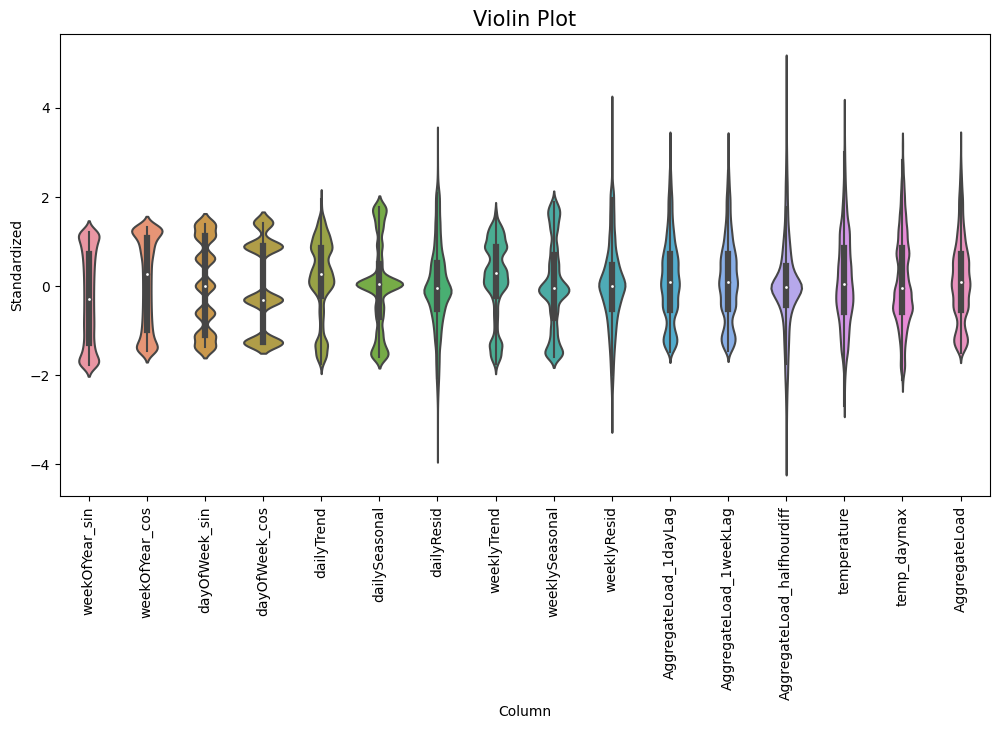

In [249]:
# Visualize distribution of the features
# df_std = (mergeData - train_mean) / train_std
df_std = mergeDataNormed.melt(var_name='Column', value_name='Standardized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Standardized', data=df_std, size=15)
_ = ax.set_xticklabels(mergeDataNormed.keys(), rotation=90)
plt.title('Violin Plot', size=15)
plt.savefig('violin_plot.png', format='png')

In [250]:
import numpy as np
import pandas as pd
from sklearn.metrics import mutual_info_score

# Split the data into features and target
X = mergeDataNormed.drop(columns=['AggregateLoad'])
y = mergeDataNormed['AggregateLoad']

# Calculate mutual information between each feature and the target variable
mutual_information_scores = []
for feature in X.columns:
    mutual_information_score = mutual_info_score(X[feature], y)
    mutual_information_scores.append([feature,mutual_information_score])
    
MISdf = pd.DataFrame(mutual_information_scores, columns=['Feature', 'Mutual information score'])
# Print the mutual information scores
# print('Mutual information scores:', mutual_information_scores)
print(MISdf.sort_values('Mutual information score', ascending=False))

                       Feature  Mutual information score
4                   dailyTrend                 10.576736
6                   dailyResid                 10.576736
7                  weeklyTrend                 10.576736
9                  weeklyResid                 10.576736
10       AggregateLoad_1dayLag                 10.576559
12  AggregateLoad_halfhourdiff                 10.576488
11      AggregateLoad_1weekLag                 10.576453
13                 temperature                  8.320758
14                 temp_daymax                  6.456708
8               weeklySeasonal                  5.816821
5                dailySeasonal                  3.870918
0               weekOfYear_sin                  3.767622
1               weekOfYear_cos                  3.691730
3                dayOfWeek_cos                  1.945658
2                dayOfWeek_sin                  1.945658


In [177]:
from pandas_profiling import ProfileReport

# profile = ProfileReport(mergeDataNormed, tsmode=True, sortby=mergeDataNormed.index.astype(int))
profile = ProfileReport(mergeDataNormed, tsmode=True)
profile.to_file('mergeDataNormed profile_report.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [251]:
class WindowGenerator():
    # https://www.tensorflow.org/tutorials/structured_data/time_series#1_indexes_and_offsets
  def __init__(self, input_width, label_width, shift,
               train_df=train_data, val_df=val_data, test_df=test_data,
               label_columns=None):
    # print('\nWindowGenerator.__init__\n')
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df
    # print('\nlabel_columns:\n', label_columns)
    # Work out the label column indices.
    self.label_columns = label_columns
    self.num_out_features = train_df.shape[1] # default to predicting all input columns
    
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
      self.num_out_features = len(label_columns) # JS added this
      # print('\nself.num_out_features:', self.num_out_features)
      
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [252]:
def split_window(self, features):
    # https://www.tensorflow.org/tutorials/structured_data/time_series#2_split
  # print('\nsplit_window\n', features)
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [253]:
def plot(self, model=None, plot_col='AggregateLoad', max_subplots=3):
    # https://www.tensorflow.org/tutorials/structured_data/time_series#3_plot
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [254]:
def make_dataset(self, data):
    # https://www.tensorflow.org/tutorials/structured_data/time_series#4_create_tfdatadatasets
  # print('\nmake_dataset\n', data)
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      seed=randomState,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [256]:
# https://www.tensorflow.org/tutorials/structured_data/time_series#4_create_tfdatadatasets
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

Total window size: 96
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label indices: [48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]
Label column name(s): ['AggregateLoad']

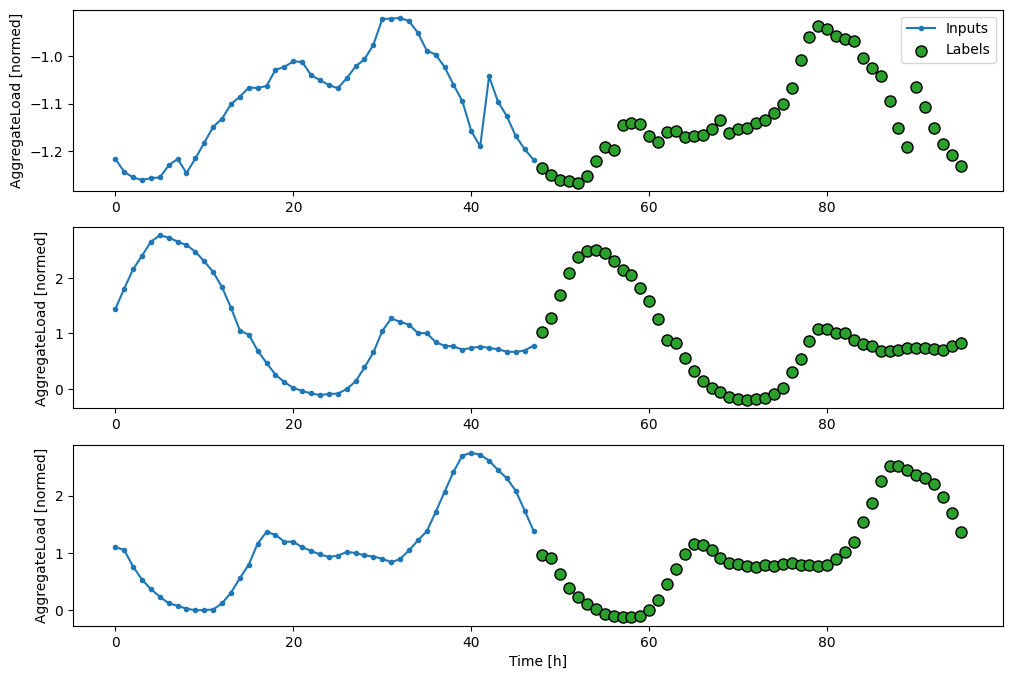

In [257]:
# Prepare data for one-shot multi-step
OUT_STEPS = 48 # 24 hour forecast
# IN_STEPS = 336 # look back 1 week
IN_STEPS = 48 # look back 1 day
multi_window = WindowGenerator(input_width=IN_STEPS,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               label_columns=['AggregateLoad'],
                              train_df=train_data, val_df=val_data, test_df=test_data,)

num_out_features = multi_window.num_out_features
# print('\nnum_out_features: ', num_out_features)
multi_window.plot()
multi_window

In [258]:
# capture performnce of models
multi_val_performance = {}
multi_test_performance = {}

In [259]:
MAX_EPOCHS = 100

def compile_and_fit(model, window, patience=5):
  # https://www.tensorflow.org/tutorials/structured_data/time_series#linear_model
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  checkpoint_filepath = '/tmp/' + model.name + '/checkpoint.keras'
  checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_filepath, 
                    monitor="val_loss", mode="min", 
                    save_best_only=True, verbose=1)
    
  # print('\nwindow.train:\n', window.train)  
  # print('\nwindow.val:\n', window.val)  
  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping, checkpoint])

  # restore weights from epoch with best loss against validation dataset
  model.load_weights(checkpoint_filepath)
    
  return history

In [260]:
# Baseline Model: Naive 1 week persistence
OneWeekNPeriods = 48 * 7
NaiveForecast = mergeData.AggregateLoad.shift(OneWeekNPeriods).copy()

print(NaiveForecast.info())
print(NaiveForecast.describe())

<class 'pandas.core.series.Series'>
RangeIndex: 39223 entries, 0 to 39222
Series name: AggregateLoad
Non-Null Count  Dtype  
--------------  -----  
38887 non-null  float64
dtypes: float64(1)
memory usage: 306.6 KB
None
count    38887.000000
mean       899.357129
std        514.693658
min          7.664000
25%        535.600000
50%        876.029000
75%       1222.347999
max       2606.830999
Name: AggregateLoad, dtype: float64


In [261]:
# Baseline Model: Naive 1 week persistence
OneWeekNPeriods = 48 * 7
NaiveForecast = mergeData.AggregateLoad.shift(OneWeekNPeriods).copy()

print(NaiveForecast.info())
print(NaiveForecast.describe())

<class 'pandas.core.series.Series'>
RangeIndex: 39223 entries, 0 to 39222
Series name: AggregateLoad
Non-Null Count  Dtype  
--------------  -----  
38887 non-null  float64
dtypes: float64(1)
memory usage: 306.6 KB
None
count    38887.000000
mean       899.357129
std        514.693658
min          7.664000
25%        535.600000
50%        876.029000
75%       1222.347999
max       2606.830999
Name: AggregateLoad, dtype: float64


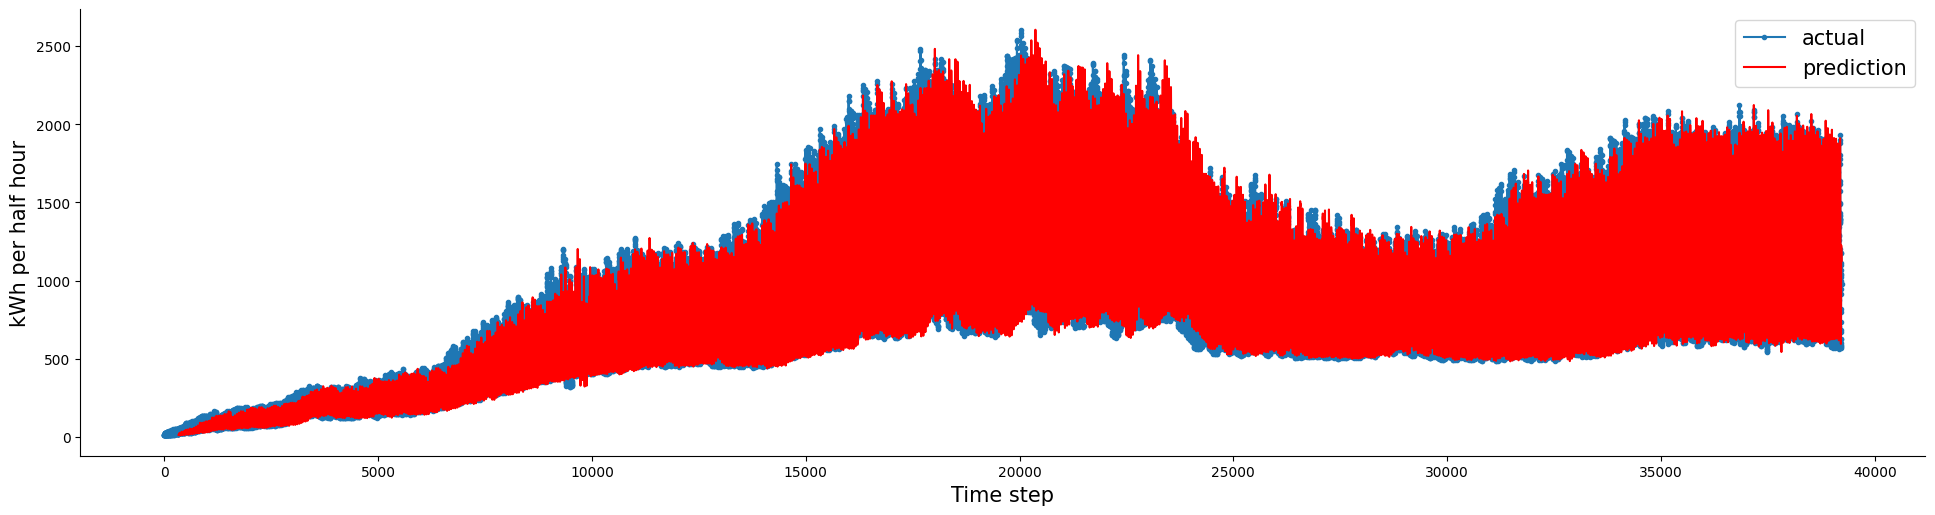

In [262]:
# visualize naive forecast and actuals for entire dataset
prediction_plot(mergeData.AggregateLoad, NaiveForecast)

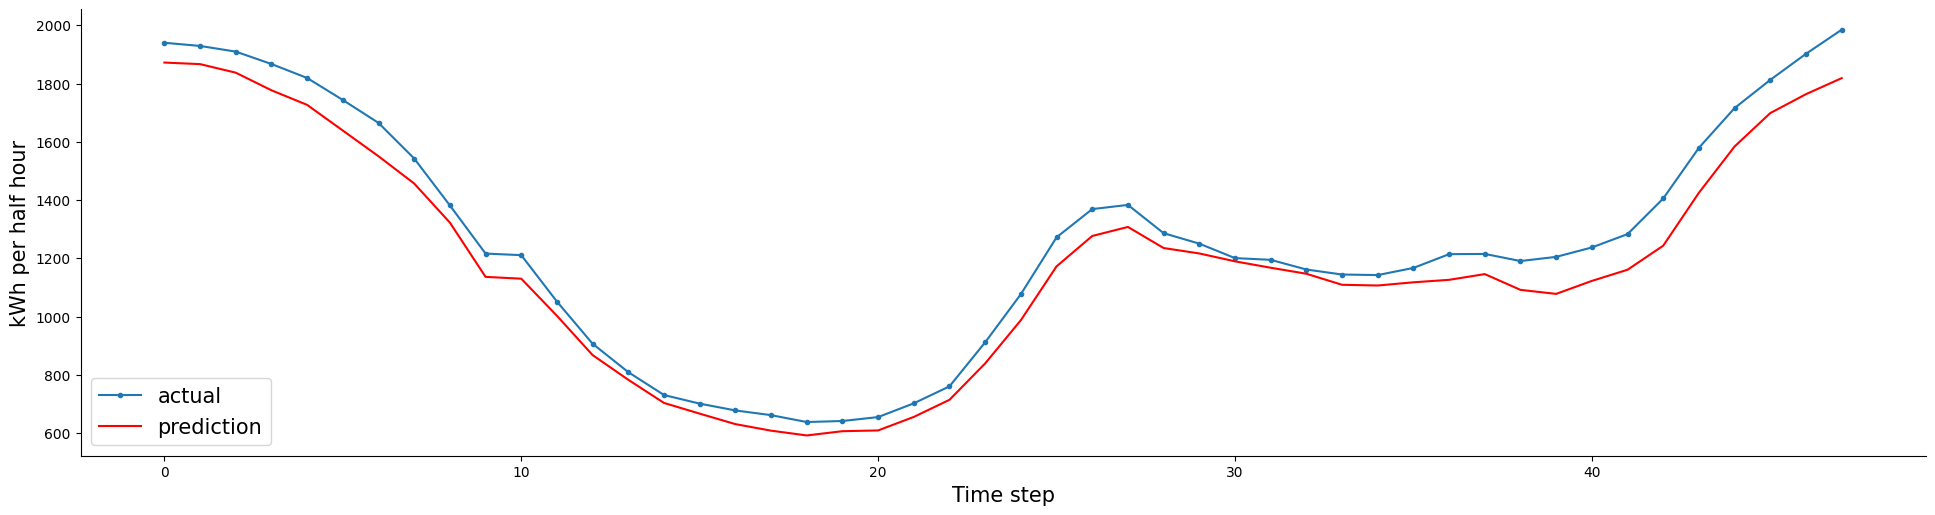

In [263]:
prediction_plot(mergeData.AggregateLoad[train_size+val_size:train_size+val_size+OUT_STEPS], NaiveForecast[train_size+val_size:train_size+val_size+OUT_STEPS])

In [264]:
# standardize the baseline 
NaiveForecastNormed = NaiveForecast.transform(lambda x: (x - train_mean) / train_std)
NaiveForecastNormed.describe()

weekOfYear_sin  weekOfYear_cos  dayOfWeek_sin  dayOfWeek_cos  \
count    38887.000000    38887.000000   38887.000000   38887.000000   
mean      1347.267719     1252.366435    1271.796010    1271.939889   
std        771.191454      716.760783     727.835316     727.917631   
min         11.198951       10.597363      10.840604      10.841873   
25%        802.232074      745.799391     757.402096     757.487799   
50%       1312.314006     1219.879755    1238.807383    1238.947532   
75%       1831.221222     1702.162514    1728.541800    1728.737336   
max       3905.661896     3630.189224    3686.358078    3686.775035   

         dailyTrend  dailySeasonal    dailyResid   weeklyTrend  \
count  38887.000000   38887.000000  38887.000000  38887.000000   
mean       0.145733       3.465033      5.249703      0.146453   
std        1.105787       1.983006      3.004189      1.109888   
min       -1.770014       0.029528      0.045025     -1.776398   
25%       -0.635777       2.063554      3.126507     -0.637954   
50%        0.095614       3.375155      5.113540      0.096148   
75%        0.839659       4.709449      7.134952      0.842952   
max        3.814134      10.043570     15.215969      3.828457   

       weeklySeasonal   weeklyResid  AggregateLoad_1dayLag  \
count    38887.000000  38887.000000           38887.000000   
mean         3.399718      5.310347               0.126421   
std          1.945678      3.039095               0.934408   
min          0.028883      0.045195              -1.492417   
25%          2.024620      3.162482              -0.533968   
50%          3.311532      5.172602               0.084069   
75%          4.620709      7.217501               0.712799   
max          9.854421     15.392414               3.226280   

       AggregateLoad_1weekLag  AggregateLoad_halfhourdiff   temperature  \
count            38887.000000                38887.000000  38887.000000   
mean                 0.142101                   14.187954    154.920768   
std                  0.924795                    8.119951     89.636392   
min                 -1.460081                    0.120354     -0.371908   
25%                 -0.511493                    8.449220     91.570703   
50%                  0.100186                   13.819923    150.858061   
75%                  0.722447                   19.283548    211.171192   
max                  3.210069                   41.125540    452.285609   

        temp_daymax  AggregateLoad  
count  38887.000000   38887.000000  
mean     144.698122       0.123432  
std       84.016305       0.935886  
min       -0.857902      -1.497965  
25%       85.320024      -0.538001  
50%      140.890141       0.081014  
75%      197.421716       0.710738  
max      423.418568       3.228193

In [265]:
# calculate error for baseline naive model (Normed)
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# calculate error for naive model on validation set
valNaiveMAE = mean_absolute_error(mergeDataNormed.AggregateLoad[train_size:train_size+val_size], NaiveForecastNormed.AggregateLoad[train_size:train_size+val_size])

# calculate error for naive model on test set
testNaiveMAE = mean_absolute_error(mergeDataNormed.AggregateLoad[train_size+val_size:], NaiveForecastNormed.AggregateLoad[train_size+val_size:])

print('valNaiveMAE: ', valNaiveMAE)
print('testNaiveMAE: ', testNaiveMAE)

valNaiveMAE:  0.08659517831698184
testNaiveMAE:  0.11880658340126943


In [266]:
# calculate error for baseline naive model (not normed)
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print('Naive Root Mean Squared Error(RMSE): %.2f; Naive Mean Absolute Error(MAE) : %.2f; Naive Mean Absolute Percantage Error(MAPE) : %.2f '
      % (np.sqrt(mean_squared_error(mergeData.AggregateLoad[OneWeekNPeriods:], NaiveForecast[OneWeekNPeriods:])),
         mean_absolute_error(mergeData.AggregateLoad[OneWeekNPeriods:], NaiveForecast[OneWeekNPeriods:]),
         mean_absolute_percentage_error(mergeData.AggregateLoad[OneWeekNPeriods:], NaiveForecast[OneWeekNPeriods:])))

# calculate error for naive model on validation set
valNaiveMAE = mean_absolute_error(mergeData.AggregateLoad[train_size:train_size+val_size], NaiveForecast[train_size:train_size+val_size])

# calculate error for naive model on test set
testNaiveMAE = mean_absolute_error(mergeData.AggregateLoad[train_size+val_size:], NaiveForecast[train_size+val_size:])

print('valNaiveMAE: ', valNaiveMAE)
print('testNaiveMAE: ', testNaiveMAE)

Naive Root Mean Squared Error(RMSE): 94.10; Naive Mean Absolute Error(MAE) : 61.45; Naive Mean Absolute Percantage Error(MAPE) : 0.08 
valNaiveMAE:  47.623314896749136
testNaiveMAE:  65.33808744425188


In [267]:
# function for plotting the train and test loss curves
def plot_model_loss(history):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show()
    return

In [268]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                        metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance['Baseline'] = repeat_baseline.evaluate(mergeDataNormed.AggregateLoad[train_size:train_size+val_size], NaiveForecastNormed.AggregateLoad[train_size:train_size+val_size], verbose=0)
multi_test_performance['Baseline'] = repeat_baseline.evaluate(mergeDataNormed.AggregateLoad[train_size+val_size:], NaiveForecastNormed.AggregateLoad[train_size+val_size:], verbose=0)
print(multi_val_performance['Baseline'], multi_test_performance['Baseline'])

[0.016361407935619354, 0.08659519255161285] [0.03564714640378952, 0.11880656331777573]


Multi Layer Perceptron (MLP) Model

Epoch 1/100
856/856 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2653 - mean_absolute_error: 0.3497
Epoch 1: val_loss improved from inf to 0.09236, saving model to /tmp/MLP/checkpoint.keras
856/856 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.2651 - mean_absolute_error: 0.3496 - val_loss: 0.0924 - val_mean_absolute_error: 0.2215
Epoch 2/100
845/856 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0853 - mean_absolute_error: 0.1952
Epoch 2: val_loss improved from 0.09236 to 0.07923, saving model to /tmp/MLP/checkpoint.keras
856/856 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0853 - mean_absolute_error: 0.1951 - val_loss: 0.0792 - val_mean_absolute_error: 0.2040
Epoch 3/100
836/856 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0745 - mean_absolute_error: 0.1819
Epoch 3: val_loss improved from 0.07923 to 0.07045, saving model to /tmp/MLP/checkpoint.keras
856/856 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0745 - mean_absolute_error: 0.1818 - val_loss: 0.0704 - val_mean_absolute_error: 0.1920
Epoch 4/100

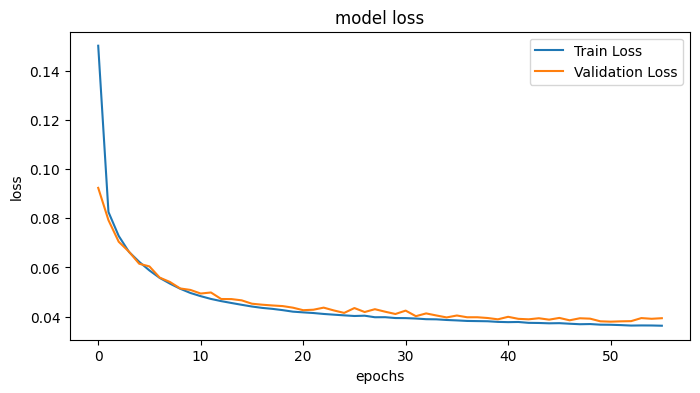

243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0381 - mean_absolute_error: 0.1414


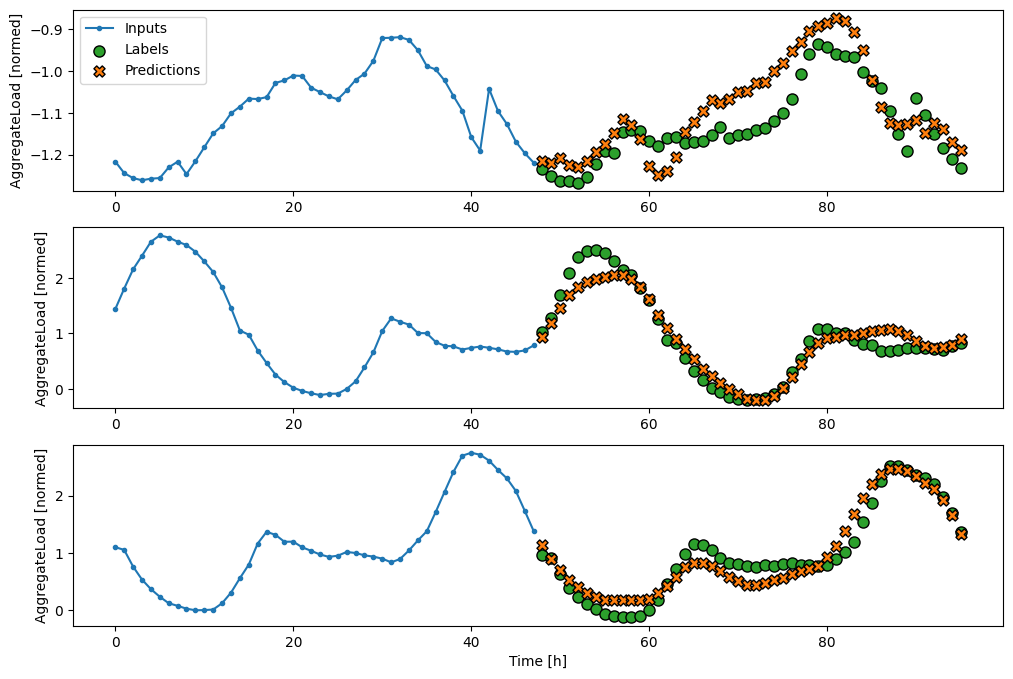

In [269]:
multi_MLP_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(64, activation='relu'),
    # tf.keras.layers.Dense(32, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_out_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_out_features])
], name="MLP")

history = compile_and_fit(multi_MLP_model, multi_window)
multi_MLP_model.save('multi_MLP_model.keras')
plot_model_loss(history)

multi_val_performance['MLP'] = multi_MLP_model.evaluate(multi_window.val)
multi_test_performance['MLP'] = multi_MLP_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_MLP_model)

Convolutional Neural Network (CNN) Model

Epoch 1/100
856/856 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1664 - mean_absolute_error: 0.2587
Epoch 1: val_loss improved from inf to 0.02838, saving model to /tmp/CNN/checkpoint.keras
856/856 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.1662 - mean_absolute_error: 0.2586 - val_loss: 0.0284 - val_mean_absolute_error: 0.1281
Epoch 2/100
835/856 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0254 - mean_absolute_error: 0.1129
Epoch 2: val_loss improved from 0.02838 to 0.02181, saving model to /tmp/CNN/checkpoint.keras
856/856 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0253 - mean_absolute_error: 0.1128 - val_loss: 0.0218 - val_mean_absolute_error: 0.1114
Epoch 3/100
841/856 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0204 - mean_absolute_error: 0.1019
Epoch 3: val_loss improved from 0.02181 to 0.01840, saving model to /tmp/CNN/checkpoint.keras
856/856 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0203 - mean_absolute_error: 0.1019 - val_loss: 0.0184 - val_mean_absolute_error: 0.1031
Epoch 4/100

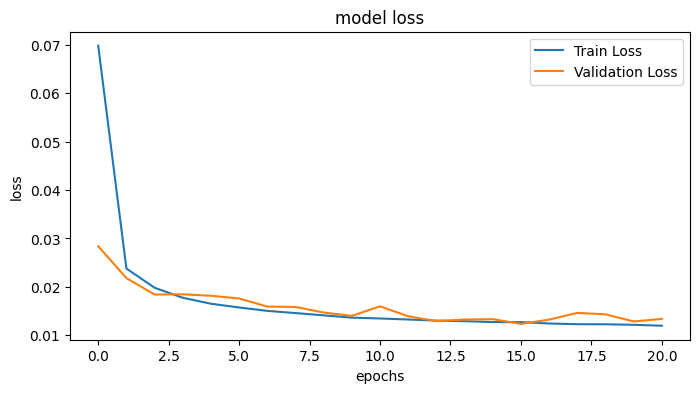

243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0124 - mean_absolute_error: 0.0852


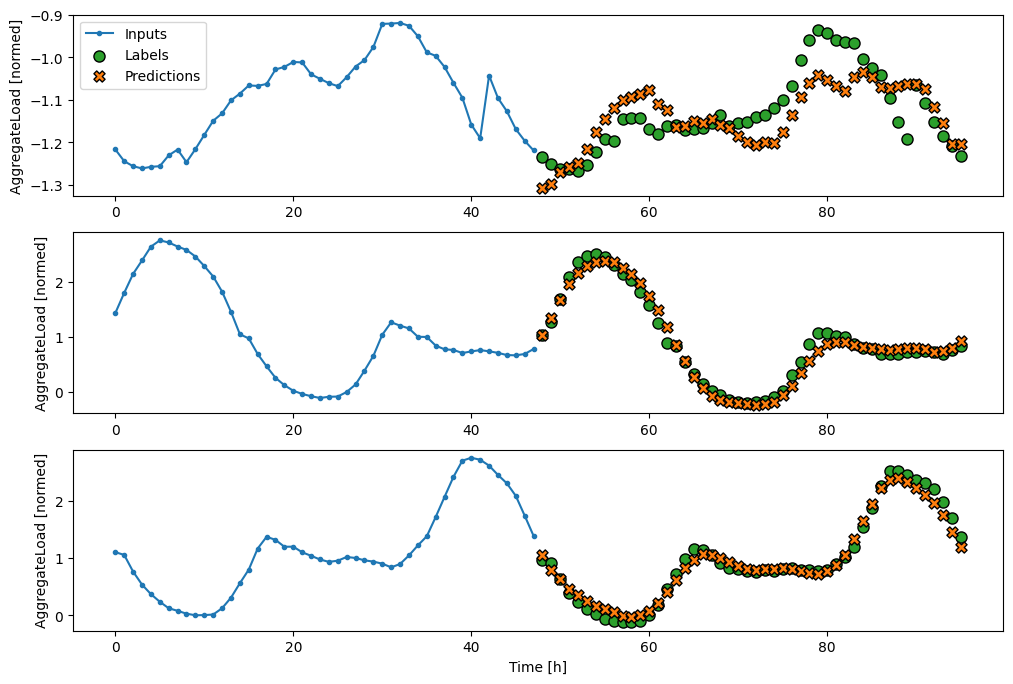

In [270]:
CONV_WIDTH = 10
multi_cnn_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(64, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    # tf.keras.layers.Dense(32),
    tf.keras.layers.Dense(OUT_STEPS*num_out_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_out_features])
], name="CNN")

history = compile_and_fit(multi_cnn_model, multi_window)
multi_cnn_model.save('multi_cnn_model.keras')
plot_model_loss(history)
# IPython.display.clear_output()

multi_val_performance['CNN'] = multi_cnn_model.evaluate(multi_window.val)
multi_test_performance['CNN'] = multi_cnn_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_cnn_model)

Recurrent Neural Network (RNN) Model

Epoch 1/100
856/856 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1947 - mean_absolute_error: 0.2934
Epoch 1: val_loss improved from inf to 0.02244, saving model to /tmp/RNN/checkpoint.keras
856/856 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.1946 - mean_absolute_error: 0.2933 - val_loss: 0.0224 - val_mean_absolute_error: 0.1171
Epoch 2/100
856/856 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0203 - mean_absolute_error: 0.1045
Epoch 2: val_loss improved from 0.02244 to 0.01584, saving model to /tmp/RNN/checkpoint.keras
856/856 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0203 - mean_absolute_error: 0.1045 - val_loss: 0.0158 - val_mean_absolute_error: 0.0968
Epoch 3/100
846/856 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0149 - mean_absolute_error: 0.0886
Epoch 3: val_loss improved from 0.01584 to 0.01404, saving model to /tmp/RNN/checkpoint.keras
856/856 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0149 - mean_absolute_error: 0.0885 - val_loss: 0.0140 - val_mean_absolute_error: 0.0906
Epoch 4/100

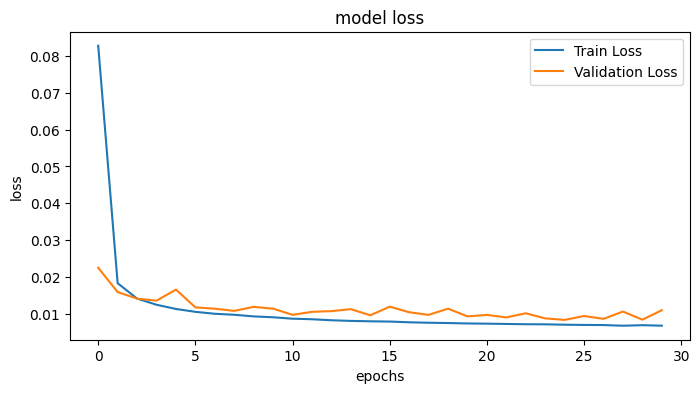

243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0083 - mean_absolute_error: 0.0681


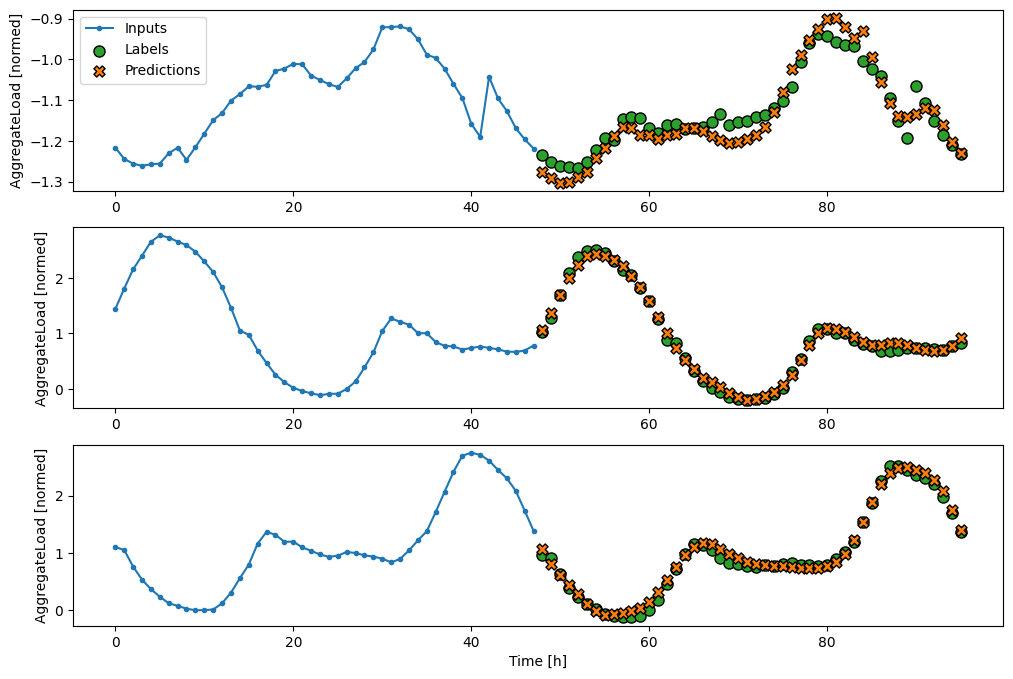

In [271]:
multi_rnn_model = tf.keras.Sequential([
    # tf.keras.layers.SimpleRNN(32, return_sequences=True),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.SimpleRNN(64, return_sequences=False),
    tf.keras.layers.Dense(OUT_STEPS*num_out_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_out_features])
], name="RNN")

history = compile_and_fit(multi_rnn_model, multi_window)
plot_model_loss(history)
multi_rnn_model.save('multi_rnn_model.keras')
# IPython.display.clear_output()

multi_val_performance['RNN'] = multi_rnn_model.evaluate(multi_window.val)
multi_test_performance['RNN'] = multi_rnn_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_rnn_model)

Long Short Term Memory (LSTM) Model

Epoch 1/100
848/856 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2069 - mean_absolute_error: 0.2920
Epoch 1: val_loss improved from inf to 0.01704, saving model to /tmp/LSTM/checkpoint.keras
856/856 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.2055 - mean_absolute_error: 0.2907 - val_loss: 0.0170 - val_mean_absolute_error: 0.0993
Epoch 2/100
848/856 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0130 - mean_absolute_error: 0.0815
Epoch 2: val_loss improved from 0.01704 to 0.01222, saving model to /tmp/LSTM/checkpoint.keras
856/856 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0130 - mean_absolute_error: 0.0814 - val_loss: 0.0122 - val_mean_absolute_error: 0.0821
Epoch 3/100
851/856 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0091 - mean_absolute_error: 0.0679
Epoch 3: val_loss improved from 0.01222 to 0.01021, saving model to /tmp/LSTM/checkpoint.keras
856/856 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0091 - mean_absolute_error: 0.0679 - val_loss: 0.0102 - val_mean_absolute_error: 0.0751
Epoch 4/

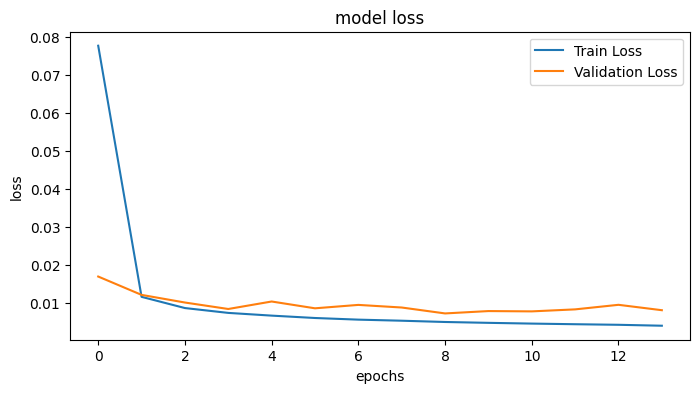

243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0073 - mean_absolute_error: 0.0626


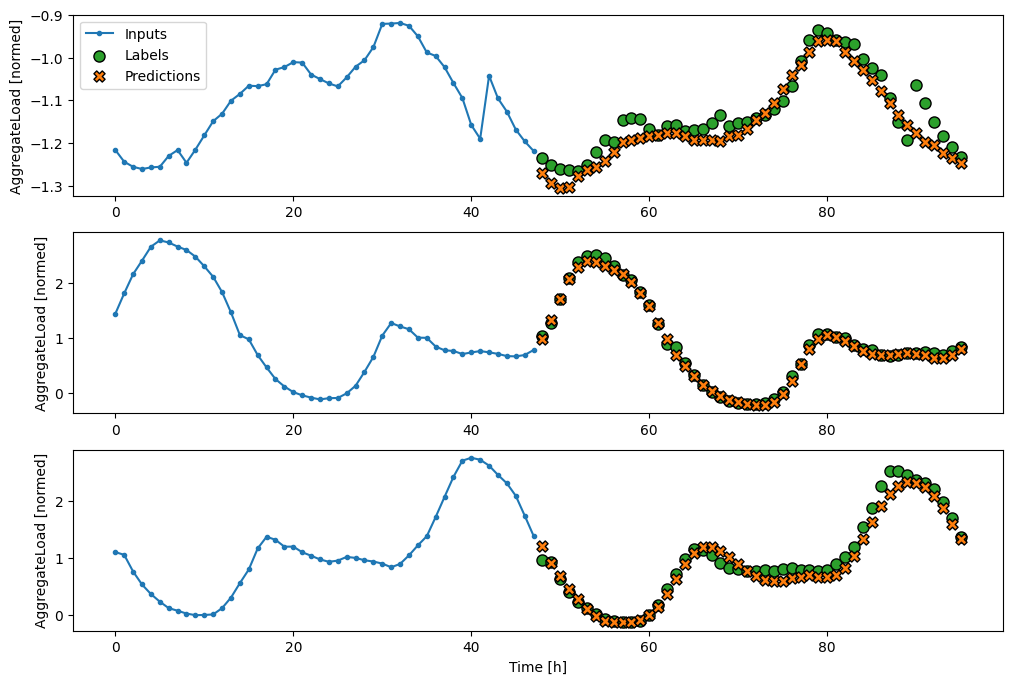

In [272]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # tf.keras.layers.LSTM(32,return_sequences=True),
    tf.keras.layers.LSTM(64,return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_out_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_out_features])
], name="LSTM")

start_time = time.time()
history = compile_and_fit(multi_lstm_model, multi_window)
print('%s seconds' % (time.time() - start_time))
multi_lstm_model.save('multi_lstm_model.keras')
plot_model_loss(history)
# IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_test_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

GRU Model

Epoch 1/100
850/856 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2037 - mean_absolute_error: 0.2916
Epoch 1: val_loss improved from inf to 0.01731, saving model to /tmp/GRU/checkpoint.keras
856/856 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.2027 - mean_absolute_error: 0.2906 - val_loss: 0.0173 - val_mean_absolute_error: 0.1023
Epoch 2/100
851/856 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0152 - mean_absolute_error: 0.0878
Epoch 2: val_loss improved from 0.01731 to 0.01213, saving model to /tmp/GRU/checkpoint.keras
856/856 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0152 - mean_absolute_error: 0.0878 - val_loss: 0.0121 - val_mean_absolute_error: 0.0827
Epoch 3/100
845/856 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0108 - mean_absolute_error: 0.0739
Epoch 3: val_loss improved from 0.01213 to 0.01024, saving model to /tmp/GRU/checkpoint.keras
856/856 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0108 - mean_absolute_error: 0.0739 - val_loss: 0.0102 - val_mean_absolute_error: 0.0764
Epoch 4/100

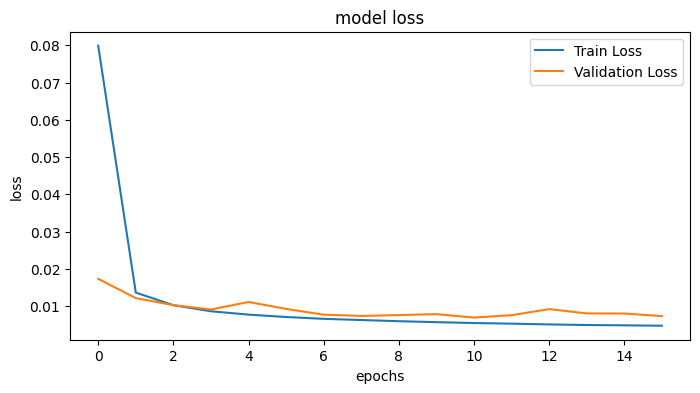

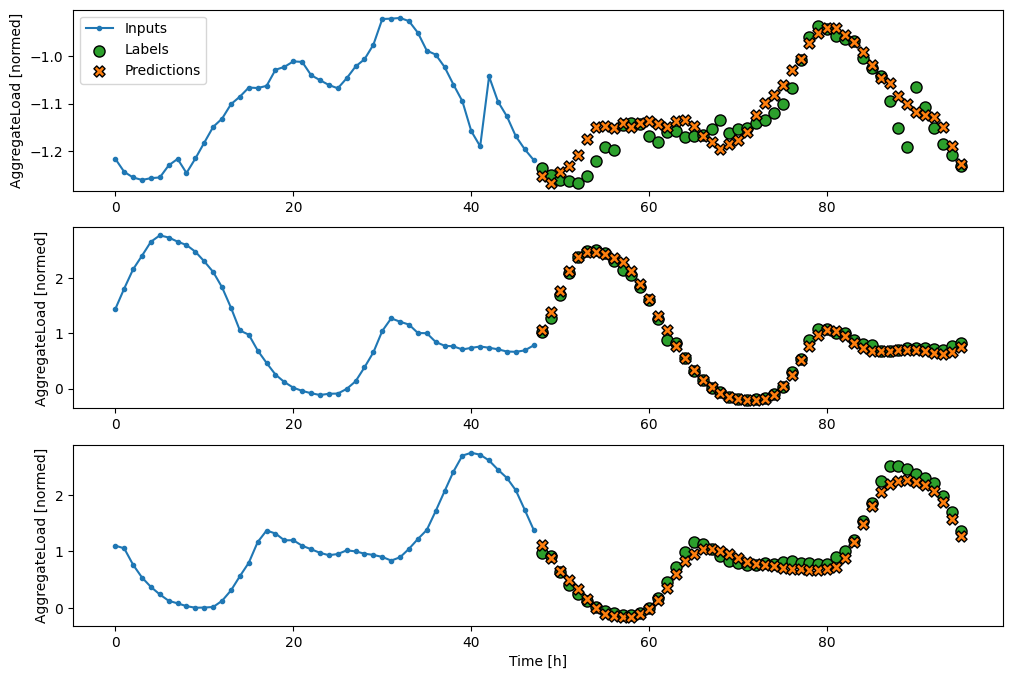

In [273]:
multi_gru_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    # tf.keras.layers.GRU(32, return_sequences=True),
    tf.keras.layers.GRU(64, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_out_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_out_features])
], name="GRU")

start_time = time.time()
history = compile_and_fit(multi_gru_model, multi_window)
print('%s seconds' % (time.time() - start_time))
multi_gru_model.save('multi_gru_model.keras')
plot_model_loss(history)
# IPython.display.clear_output()

multi_val_performance['GRU'] = multi_gru_model.evaluate(multi_window.val, verbose=0)
multi_test_performance['GRU'] = multi_gru_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_gru_model)

Model Evaluation and Selection

In [107]:
print(multi_lstm_model.metrics_names)


['loss', 'compile_metrics']


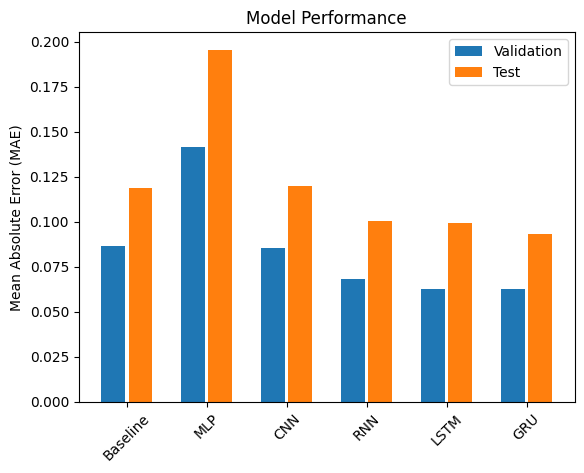

In [278]:
x = np.arange(len(multi_test_performance))
width = 0.3

metric_name = 'compile_metrics'
metric_index = multi_lstm_model.metrics_names.index(metric_name)
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_test_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_test_performance.keys(),
           rotation=45)
plt.ylabel(f'Mean Absolute Error (MAE)')
_ = plt.legend()
plt.title(f'Model Performance')
plt.savefig('model performance.png', format='png')

In [286]:
import tensorflow as tf

# Load models without re-specifying input shape
multi_MLP_model = tf.keras.models.load_model('multi_MLP_model.keras')
multi_cnn_model = tf.keras.models.load_model('multi_cnn_model.keras')
multi_rnn_model = tf.keras.models.load_model('multi_rnn_model.keras')
multi_lstm_model = tf.keras.models.load_model('multi_lstm_model.keras')
multi_gru_model = tf.keras.models.load_model('multi_gru_model.keras')

# Collect all models in a list
model_list = [multi_MLP_model, multi_cnn_model, multi_rnn_model, multi_lstm_model, multi_gru_model]

# Check input shapes (optional)
for model in model_list:
    print(f"Model: {model.name}, Input Shape: {model.input_shape}")

Model: MLP, Input Shape: (None, 48, 16)
Model: CNN, Input Shape: (None, 48, 16)
Model: RNN, Input Shape: (None, 48, 16)
Model: LSTM, Input Shape: (None, 48, 16)
Model: GRU, Input Shape: (None, 48, 16)


In [287]:
for model in model_list:
    print(model.name)

MLP
CNN
RNN
LSTM
GRU


In [117]:
for model in model_list:
    print(model.name)

MLP
CNN
RNN
LSTM
GRU


In [288]:
# store the evaluation results for all models
import pickle
with open('model eval results.pkl', 'wb') as f:
    pickle.dump(multi_val_performance, f)

with open('model test results.pkl', 'wb') as f:
    pickle.dump(multi_test_performance, f)

In [289]:
# load the evaluation results for all models
with open('model eval results.pkl', 'rb') as f:
    multi_val_performance = pickle.load(f)

with open('model test results.pkl', 'rb') as f:
    multi_test_performance = pickle.load(f)

print(multi_val_performance)
print(multi_test_performance)

{'Baseline': [0.016361407935619354, 0.08659519255161285], 'MLP': [0.037943460047245026, 0.1417025625705719], 'CNN': [0.012350698001682758, 0.08537011593580246], 'RNN': [0.008262017741799355, 0.06804043054580688], 'LSTM': [0.007348307408392429, 0.06269220262765884], 'GRU': [0.006909532472491264, 0.06257045269012451]}
{'Baseline': [0.03564714640378952, 0.11880656331777573], 'MLP': [0.07084409147500992, 0.1955535113811493], 'CNN': [0.02565392293035984, 0.1199694499373436], 'RNN': [0.01895465888082981, 0.10013867914676666], 'LSTM': [0.019438622519373894, 0.09926854074001312], 'GRU': [0.015673119574785233, 0.09297280758619308]}


In [290]:
# function to create time series dataset for feature permutation
def generateFeatPermWindow(input_width=IN_STEPS,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               label_columns=None,
                                cols_to_shuffle=None,
                              train_df=train_data, val_df=val_data, test_df=test_data):
    
    train = train_df.copy()
    val = val_df.copy()
    test = test_df.copy()
    
    # randomly shuffle shuffle the specified columns
    for col in cols_to_shuffle:
        train[col] = train[col].sample(frac=1, replace=False, random_state=randomState, ignore_index=True)
        val[col] = val[col].sample(frac=1, replace=False, random_state=randomState, ignore_index=True)
        test[col] = test[col].sample(frac=1, replace=False, random_state=randomState, ignore_index=True)
    
    """
    print('train NaNs: ', train.isnull().sum().sum())
    print('val NaNs: ', val.isnull().sum().sum())
    print('val NaNs:\n', val[val.isna().any(axis=1)])
    print('test NaNs: ', test.isnull().sum().sum())
    print('test NaNs:\n', test[test.isna().any(axis=1)])
    """

    feat_perm_window = WindowGenerator(input_width=IN_STEPS,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               label_columns=label_columns,
                              train_df=train, val_df=val, test_df=test,)
    
    return feat_perm_window

In [291]:
import numpy as np
import pandas as pd
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Define a function to calculate the permutation importance of a feature group for a given model
def calculate_permutation_importance_group(model, feature_group, baseline_val_perf, baseline_test_perf):
    """Calculates the permutation importance of a feature group for a given model.

    Args:
        model: The model to calculate the permutation importance for.
        feature_group: A list of the features in the feature group.
        baseline_val_perf: baseline performance (in MAE) of the model using all features for the validation set
        baseline_test_perf: baseline performance (in MAE) of the model using all features for the test set
        
    Returns:
        The permutation importance of the feature group for the given model.
    """

    # Shuffle the values of the features in the feature group
    feat_perm_window = generateFeatPermWindow(input_width=IN_STEPS,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               label_columns=label_columns,
                                cols_to_shuffle=feature_group,
                              train_df=train_data, val_df=val_data, test_df=test_data)
    
    # model.fit(X_shuffled, y)
    val_perf_shuffle = model.evaluate(feat_perm_window.val, verbose=1)[1] # MAE

    # Calculate the permutation importance
    # importance = np.mean(y - y_pred)
    importance = val_perf_shuffle - baseline_val_perf
    
    print('\nModel: ', model.name, feature_group, 'importance: ', importance)

    return importance

In [292]:
# Define a function to visualize the permutation importances for a given feature using a stacked bar chart
def visualize_permutation_importances_stacked_bar_stackplot(model, permutation_importances):
    """Visualizes the permutation importances for a given feature using a stacked bar chart created with the plt.stackplot() function.

    Args:
        feature: The feature to visualize the permutation importances for.
        permutation_importances: A dictionary mapping the model names to the permutation importances for the given feature.
    """

    # Get the permutation importances for each feature in a list
    importances = sorted(permutation_importances.items(), key=itemgetter(1), reverse=True)
    permutation_importances_values = list(importances.values())

    # Create a bar chart of the permutation importances
    plt.bar(importances.keys(), permutation_importances_values)
    plt.xlabel('Feature')
    plt.ylabel('Permutation Importance')
    plt.title('Permutation Importances for Model: {}'.format(model))
    plt.legend(importances.keys())
    plt.tick_params(rotation=45)
    plt.show()

In [293]:
# Calculate the permutation feature importance for each model and visualize the results
# cyclically encoded features need to be grouped together for the purposes of feature permutation importance
feature_groups = {
    'weekOfYear': ['weekOfYear_sin', 'weekOfYear_cos'],
    'dayOfWeek': ['dayOfWeek_sin', 'dayOfWeek_cos'],
#    'minuteOfDay': ['minuteOfDay_sin', 'minuteOfDay_cos'],
}

grouped_features = [value for key, value in feature_groups.items() for value in value]
print('grouped_features: ', grouped_features, '\n')

# add individual features as feature groups of one
for feature in val_data.columns:
    if feature not in grouped_features:
        feature_groups[feature] = [feature]

print('feature_groups: ', feature_groups)

permutation_importances_groups = {}
for model in model_list:
    # calculate baseline model performance with all features
    print('\ncalculate baseline model performance with all features.\n', model.name)
    val_perf = model.evaluate(multi_window.val, verbose=1)[1] # MAE
    test_perf = model.evaluate(multi_window.test, verbose=1)[1] # MAE

    for feature_group_name, feature_group in feature_groups.items():
        permutation_importance = calculate_permutation_importance_group(model, feature_group, val_perf, test_perf)
        if model.name not in permutation_importances_groups:
            permutation_importances_groups[model.name] = {}
        permutation_importances_groups[model.name][feature_group_name] = permutation_importance

grouped_features:  ['weekOfYear_sin', 'weekOfYear_cos', 'dayOfWeek_sin', 'dayOfWeek_cos'] 

feature_groups:  {'weekOfYear': ['weekOfYear_sin', 'weekOfYear_cos'], 'dayOfWeek': ['dayOfWeek_sin', 'dayOfWeek_cos'], 'dailyTrend': ['dailyTrend'], 'dailySeasonal': ['dailySeasonal'], 'dailyResid': ['dailyResid'], 'weeklyTrend': ['weeklyTrend'], 'weeklySeasonal': ['weeklySeasonal'], 'weeklyResid': ['weeklyResid'], 'AggregateLoad_1dayLag': ['AggregateLoad_1dayLag'], 'AggregateLoad_1weekLag': ['AggregateLoad_1weekLag'], 'AggregateLoad_halfhourdiff': ['AggregateLoad_halfhourdiff'], 'temperature': ['temperature'], 'temp_daymax': ['temp_daymax'], 'AggregateLoad': ['AggregateLoad']}

calculate baseline model performance with all features.
 MLP
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0381 - mean_absolute_error: 0.1414
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0714 - mean_absolute_error: 0.1964
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0520 - mean_absolute_error: 0.1675

Mo

In [294]:
permutation_importances_groups

{'MLP': {'weekOfYear': 0.026033878326416016,
  'dayOfWeek': 0.048863887786865234,
  'dailyTrend': 0.03212966024875641,
  'dailySeasonal': 0.6521894037723541,
  'dailyResid': 0.08364421129226685,
  'weeklyTrend': 0.04103781282901764,
  'weeklySeasonal': 0.5683414041996002,
  'weeklyResid': 0.053741201758384705,
  'AggregateLoad_1dayLag': 0.05230069160461426,
  'AggregateLoad_1weekLag': 0.01986442506313324,
  'AggregateLoad_halfhourdiff': 0.1463354229927063,
  'temperature': 0.13148191571235657,
  'temp_daymax': 0.12675663828849792,
  'AggregateLoad': 0.5121631920337677},
 'CNN': {'weekOfYear': 0.02146211266517639,
  'dayOfWeek': 0.05628819018602371,
  'dailyTrend': 0.025811374187469482,
  'dailySeasonal': 0.4015902653336525,
  'dailyResid': 0.13315292447805405,
  'weeklyTrend': 0.02577286958694458,
  'weeklySeasonal': 0.15437131375074387,
  'weeklyResid': 0.08087273687124252,
  'AggregateLoad_1dayLag': 0.03815367817878723,
  'AggregateLoad_1weekLag': 0.02948145568370819,
  'AggregateLoa

In [295]:
from operator import itemgetter, attrgetter
# Define a function to visualize the permutation importances for a given feature using a stacked bar chart
def visualize_permutation_importances_stacked_bar_stackplot(model, permutation_importances):
    """Visualizes the permutation importances for a given feature using a stacked bar chart created with the plt.stackplot() function.

    Args:
        feature: The feature to visualize the permutation importances for.
        permutation_importances: A dictionary mapping the model names to the permutation importances for the given feature.
    """

    # Get the permutation importances for each feature in a list
    importances = sorted(permutation_importances.items(), key=itemgetter(1), reverse=True)
    print(importances)
    df = pd.DataFrame(importances, columns=['label', 'value'])
    labels = df['label'].tolist()
    values = df['value'].tolist()


    # Create a stacked bar chart of the permutation importances
    plt.bar(labels, values)
    plt.xlabel('Feature')
    plt.ylabel('Permutation Importance')
    plt.title('Permutation Importances for Model: {}'.format(model))
    plt.legend(labels)
    plt.tick_params(rotation=90)
    plt.show()

[('dailySeasonal', 0.6521894037723541), ('weeklySeasonal', 0.5683414041996002), ('AggregateLoad', 0.5121631920337677), ('AggregateLoad_halfhourdiff', 0.1463354229927063), ('temperature', 0.13148191571235657), ('temp_daymax', 0.12675663828849792), ('dailyResid', 0.08364421129226685), ('weeklyResid', 0.053741201758384705), ('AggregateLoad_1dayLag', 0.05230069160461426), ('dayOfWeek', 0.048863887786865234), ('weeklyTrend', 0.04103781282901764), ('dailyTrend', 0.03212966024875641), ('weekOfYear', 0.026033878326416016), ('AggregateLoad_1weekLag', 0.01986442506313324)]


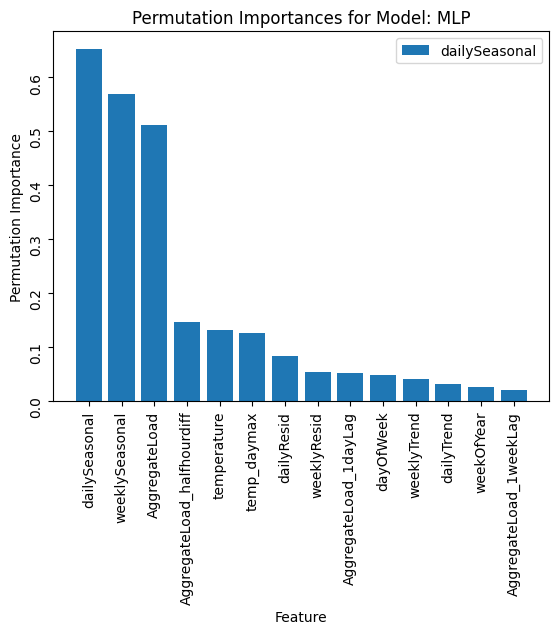

[('AggregateLoad', 0.5612731650471687), ('dailySeasonal', 0.4015902653336525), ('AggregateLoad_halfhourdiff', 0.19522280246019363), ('weeklySeasonal', 0.15437131375074387), ('dailyResid', 0.13315292447805405), ('weeklyResid', 0.08087273687124252), ('dayOfWeek', 0.05628819018602371), ('AggregateLoad_1dayLag', 0.03815367817878723), ('AggregateLoad_1weekLag', 0.02948145568370819), ('temperature', 0.027154557406902313), ('temp_daymax', 0.02607923001050949), ('dailyTrend', 0.025811374187469482), ('weeklyTrend', 0.02577286958694458), ('weekOfYear', 0.02146211266517639)]


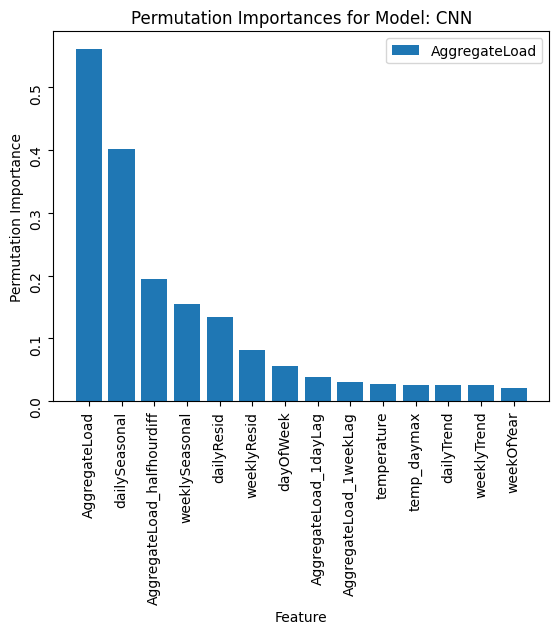

[('AggregateLoad', 0.6225640177726746), ('dailySeasonal', 0.27786654233932495), ('weeklySeasonal', 0.135329008102417), ('dailyTrend', 0.10103847086429596), ('dailyResid', 0.08586013317108154), ('AggregateLoad_halfhourdiff', 0.08328570425510406), ('weeklyTrend', 0.06291022896766663), ('weekOfYear', 0.03743574023246765), ('weeklyResid', 0.031983472406864166), ('dayOfWeek', 0.02663148194551468), ('AggregateLoad_1dayLag', 0.023201383650302887), ('temp_daymax', 0.019566699862480164), ('AggregateLoad_1weekLag', 0.010471604764461517), ('temperature', 0.009602181613445282)]


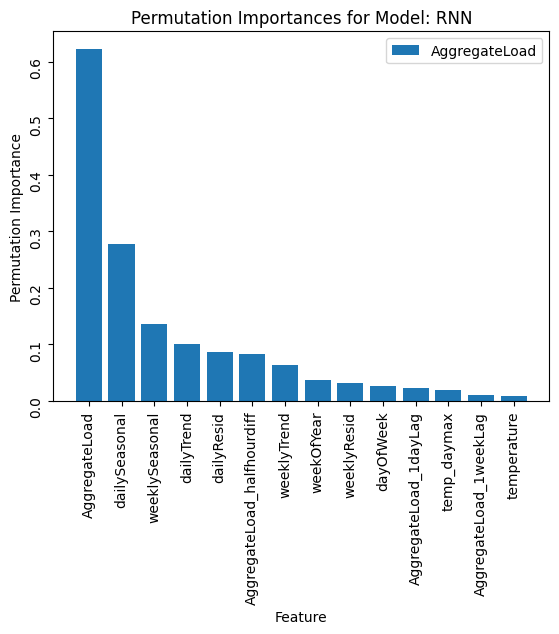

[('AggregateLoad', 0.5970151647925377), ('AggregateLoad_halfhourdiff', 0.10623525828123093), ('dailySeasonal', 0.09532908350229263), ('dailyResid', 0.03702156990766525), ('weeklySeasonal', 0.03460102528333664), ('dailyTrend', 0.029924482107162476), ('weekOfYear', 0.02738092839717865), ('weeklyResid', 0.02127007395029068), ('dayOfWeek', 0.021203070878982544), ('weeklyTrend', 0.01657891273498535), ('AggregateLoad_1dayLag', 0.013028904795646667), ('AggregateLoad_1weekLag', 0.012172579765319824), ('temp_daymax', 0.010103650391101837), ('temperature', 0.009447157382965088)]


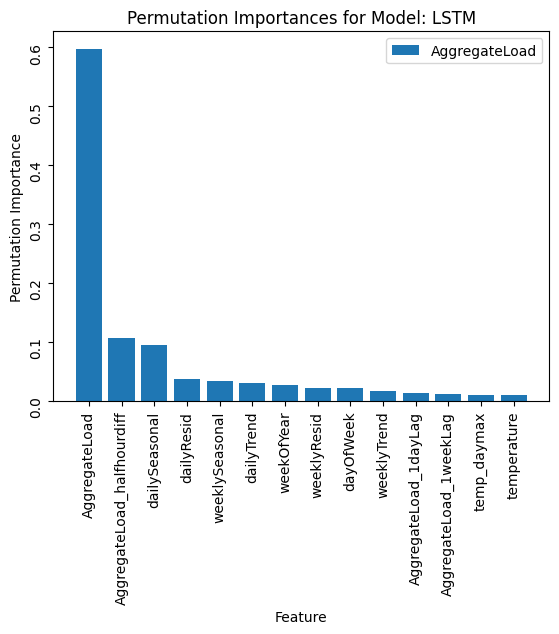

[('AggregateLoad', 0.6002566814422607), ('dailySeasonal', 0.24727731943130493), ('weeklySeasonal', 0.0872955173254013), ('AggregateLoad_halfhourdiff', 0.0768817663192749), ('dailyResid', 0.06440189480781555), ('dailyTrend', 0.03796394169330597), ('weeklyResid', 0.03296094387769699), ('dayOfWeek', 0.025233179330825806), ('weekOfYear', 0.022131241858005524), ('weeklyTrend', 0.015258632600307465), ('AggregateLoad_1dayLag', 0.014239028096199036), ('temp_daymax', 0.011854790151119232), ('AggregateLoad_1weekLag', 0.0061347633600234985), ('temperature', 0.005345791578292847)]


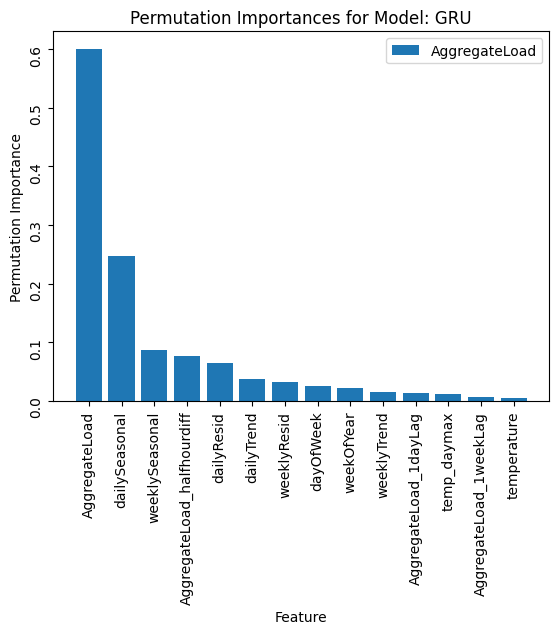

In [296]:
# Visualize the permutation importances for each feature using a stacked bar chart
for model, permutation_importances in permutation_importances_groups.items():
    visualize_permutation_importances_stacked_bar_stackplot(model, permutation_importances)

In [297]:
# build a single record dataset from start of the test dataset
# print(mergeDataNormed)
# print(train_size+test_size-IN_STEPS)
# print(mergeDataNormed.iloc[train_size+test_size-IN_STEPS:train_size+test_size])

oneDay_ds = tf.keras.utils.timeseries_dataset_from_array(
      data=test_data[:IN_STEPS],
      targets=None,
      sequence_length=IN_STEPS,
      sequence_stride=1,
      shuffle=False,
      batch_size=32,)

# get the prediction
testYhatNormed = multi_gru_model.predict(oneDay_ds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


In [298]:
# print(testYhatNormed) # prediction for all input columns
print(testYhatNormed[0,:,-1]) # prediction for target column, aggregate load

[ 2.355053    2.3143506   2.2071717   2.1277068   2.014672    1.8446587
  1.6165909   1.3572072   1.0901123   0.8137522   0.54381686  0.3129182
  0.12475562 -0.00726704 -0.0963017  -0.17357418 -0.21141985 -0.24313125
 -0.26517317 -0.29054043 -0.27634987 -0.20917648 -0.05319168  0.18313453
  0.43610746  0.658183    0.7851      0.8371494   0.8168476   0.7758268
  0.70822716  0.6563532   0.6297633   0.6197296   0.62119937  0.61556023
  0.60931075  0.59769684  0.6074369   0.61757696  0.6673042   0.788379
  0.98324615  1.2156204   1.4794257   1.7377048   1.9548539   2.065281  ]


In [300]:
# Invert standardization
testYhat = (np.array(testYhatNormed) * np.array(train_std)) + np.array(train_mean)

# print(testYhat)
print(testYhat[0,:,-1])

[2126.64466832 2104.26027539 2045.3168577  2001.61485696 1939.4510227
 1845.9516214  1720.52491248 1577.87597016 1430.98624232 1279.00102904
 1130.54918086 1003.56566192  900.08501473  827.47869955  778.51378141
  736.01751926  715.20416278  697.76436998  685.64234232  671.69153082
  679.49567493  716.43791169  802.22228686  932.19069351 1071.31402314
 1193.44521703 1263.24365838 1291.8684033  1280.70338128 1258.14384599
 1220.96718464 1192.4389106  1177.81572028 1172.29763792 1173.10595448
 1170.00469241 1166.56776541 1160.18065835 1165.53723474 1171.11379622
 1198.46147375 1265.04697233 1372.21482013 1500.00983527 1645.09044713
 1787.13191459 1906.553827   1967.28354594]


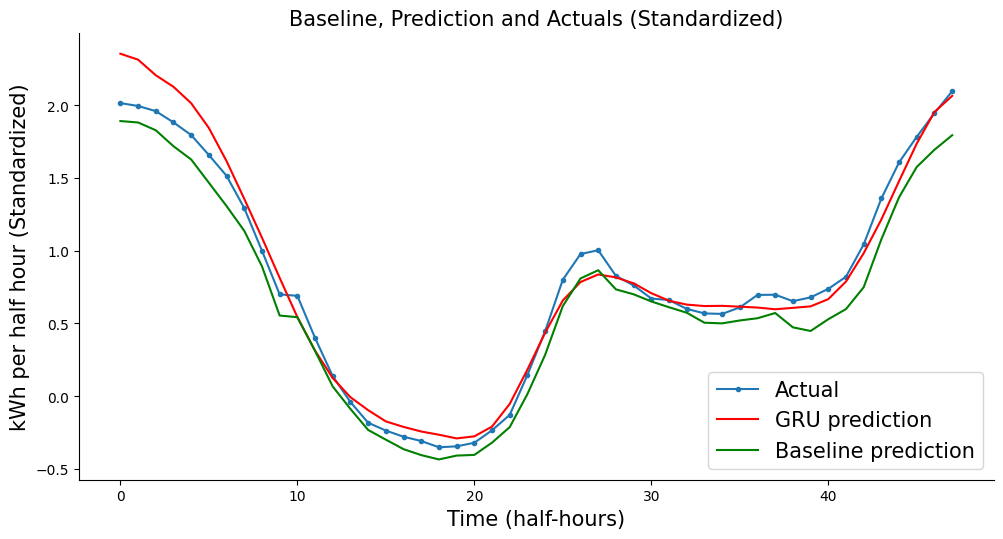

<Figure size 640x480 with 0 Axes>

In [301]:
# Plot Naive prediction, GRU prediction and Actuals for first 24 hours of the test set (normed values)
len_prediction=[x for x in range(len(testYhat[0,:,-1]))]
plt.figure(figsize=(10,5))
# plt.plot(len_prediction, test_data[:OUT_STEPS].AggregateLoad, marker='.', label="actual")
plt.plot(len_prediction, mergeDataNormed.AggregateLoad[train_size+val_size:train_size+val_size+OUT_STEPS], marker='.', label="Actual")
plt.plot(len_prediction, testYhatNormed[0,:,-1], 'r', label="GRU prediction")
plt.plot(len_prediction, NaiveForecastNormed[train_size+val_size:train_size+val_size+OUT_STEPS].AggregateLoad, 'g', label="Baseline prediction")
        
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('kWh per half hour (Standardized)', size=15)
plt.xlabel('Time (half-hours)', size=15)
plt.legend(fontsize=15)
plt.title('Baseline, Prediction and Actuals (Standardized)', size=15)
plt.show();
plt.savefig('Baseline, Prediction and Actuals (Standardized).png', format='png')

In [302]:
# calculate error for baseline naive model (Normed) first 24 hours of test set
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# calculate error for baseline naive model on validation set
valBaselineMAE = mean_absolute_error(mergeDataNormed.AggregateLoad[train_size:train_size+OUT_STEPS], NaiveForecastNormed.AggregateLoad[train_size:train_size+OUT_STEPS])

# calculate error for baseline naive model on test set
testBaselineMAE = mean_absolute_error(mergeDataNormed.AggregateLoad[train_size+val_size:train_size+val_size+OUT_STEPS], NaiveForecastNormed.AggregateLoad[train_size+val_size:train_size+val_size+OUT_STEPS])

print('valBaselineMAE: ', valBaselineMAE)
print('testBaselineMAE: ', testBaselineMAE)

valBaselineMAE:  0.049350618717389695
testBaselineMAE:  0.1356245151668344


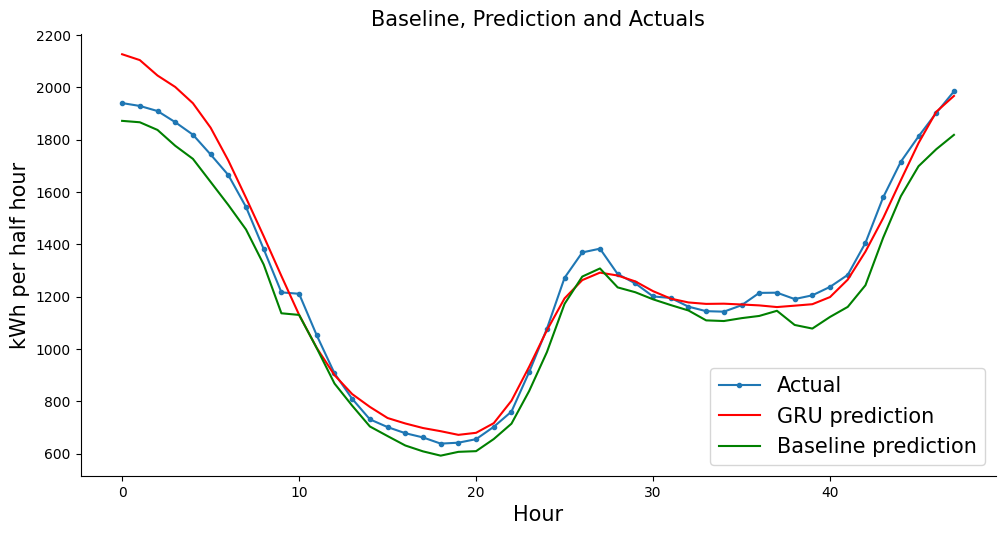

<Figure size 640x480 with 0 Axes>

In [303]:
len_prediction=[x for x in range(len(testYhat[0,:,-1]))]
plt.figure(figsize=(10,5))
# plt.plot(len_prediction, test_data[:OUT_STEPS].AggregateLoad, marker='.', label="actual")
plt.plot(len_prediction, mergeData.AggregateLoad[train_size+val_size:train_size+val_size+OUT_STEPS], marker='.', label="Actual")
plt.plot(len_prediction, testYhat[0,:,-1], 'r', label="GRU prediction")
plt.plot(len_prediction, NaiveForecast[train_size+val_size:train_size+val_size+OUT_STEPS], 'g', label="Baseline prediction")
        
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('kWh per half hour', size=15)
plt.xlabel('Hour', size=15)
plt.legend(fontsize=15)
plt.title('Baseline, Prediction and Actuals', size=15)
plt.show()
plt.savefig('Baseline, Prediction and Actuals.png', format='png')

In [304]:
# calculate error for baseline naive model first 24 hours of test set
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# calculate error for baseline naive model on test set
testBaselineMAE1day = mean_absolute_error(mergeData.AggregateLoad[train_size+val_size:train_size+val_size+OUT_STEPS], NaiveForecast[train_size+val_size:train_size+val_size+OUT_STEPS])

# calculate error for baseline naive model on test set
testModelMAE1day = mean_absolute_error(mergeData.AggregateLoad[train_size+val_size:train_size+val_size+OUT_STEPS], testYhat[0,:,-1])

print('testBaselineMAE1day: ', testBaselineMAE1day)
print('testModelMAE1day: ', testModelMAE1day)
print('Model accuracy absolute improvement: ', testBaselineMAE1day - testModelMAE1day)
print('Model accuracy % improvement: ', (testBaselineMAE1day - testModelMAE1day) / testBaselineMAE1day * 100)

testBaselineMAE1day:  74.58716661874992
testModelMAE1day:  49.77271620852963
Model accuracy absolute improvement:  24.81445041022029
Model accuracy % improvement:  33.26906160286073
